<div style="border:solid Chocolate 2px; padding: 40px">

<b> Максим, привет!👋</b>

Меня зовут Алексей Гриб, и я буду ревьюером твоего проекта. 

Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель ревью - не искать ошибки в твоём проекте, а помочь тебе сделать твою работу ещё лучше, устранив недочёты и приблизив её к реальным задачам аналитика. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Критичные ошибки, которые обязательно нужно исправить.
</div>

Я не смогу принять проект, если в нём будет хотя бы одна критичная ошибка или несколько некритичных ошибок - тогда проект нужно будет немного доработать. Но это нестрашно - я обязательно дам тебе подсказку или укажу верное направление.
    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*твой текст*
</div>
    
Давай посмотрим на твой проект!

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цель:" data-toc-modified-id="Цель:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Цель:</a></span></li><li><span><a href="#Технологический-процесс" data-toc-modified-id="Технологический-процесс-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Технологический процесс</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Проверка-расчёта-эффективности-обогащения" data-toc-modified-id="Проверка-расчёта-эффективности-обогащения-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка расчёта эффективности обогащения</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Признаки-отсутствующие-в-data_test-данных" data-toc-modified-id="Признаки-отсутствующие-в-data_test-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Признаки отсутствующие в data_test данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверим-пропуски" data-toc-modified-id="Проверим-пропуски-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверим пропуски</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Воссоздание-train-и-test-выборки" data-toc-modified-id="Воссоздание-train-и-test-выборки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Воссоздание train и test выборки</a></span><ul class="toc-item"><li><span><a href="#Вывод:-подготовка-данных" data-toc-modified-id="Вывод:-подготовка-данных-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Вывод: подготовка данных</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Изменение-концентрации-металов-(Au,-Ag,-Pb)-на-разных-стадиях-очистки" data-toc-modified-id="Изменение-концентрации-металов-(Au,-Ag,-Pb)-на-разных-стадиях-очистки-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Изменение концентрации металов (Au, Ag, Pb) на разных стадиях очистки</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Распределение-размеров-гранул-сырья-на-обучающей-и-тестовой-выборках" data-toc-modified-id="Распределение-размеров-гранул-сырья-на-обучающей-и-тестовой-выборках-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Распределение размеров гранул сырья на обучающей и тестовой выборках</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Суммарная-концентрация-всех-веществ" data-toc-modified-id="Суммарная-концентрация-всех-веществ-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Суммарная концентрация всех веществ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-8.3.1"><span class="toc-item-num">8.3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Вывод-анализ-данных" data-toc-modified-id="Вывод-анализ-данных-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Вывод анализ данных</a></span></li></ul></li><li><span><a href="#Модель" data-toc-modified-id="Модель-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>LinearRegression</a></span><ul class="toc-item"><li><span><a href="#Результат" data-toc-modified-id="Результат-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>Результат</a></span></li></ul></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span><ul class="toc-item"><li><span><a href="#Результат" data-toc-modified-id="Результат-9.2.1"><span class="toc-item-num">9.2.1&nbsp;&nbsp;</span>Результат</a></span></li></ul></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span><ul class="toc-item"><li><span><a href="#Результат" data-toc-modified-id="Результат-9.3.1"><span class="toc-item-num">9.3.1&nbsp;&nbsp;</span>Результат</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Проверка-на-тестовой-выборке" data-toc-modified-id="Проверка-на-тестовой-выборке-9.5"><span class="toc-item-num">9.5&nbsp;&nbsp;</span>Проверка на тестовой выборке</a></span></li><li><span><a href="#DummyRegressor" data-toc-modified-id="DummyRegressor-9.6"><span class="toc-item-num">9.6&nbsp;&nbsp;</span>DummyRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-9.7"><span class="toc-item-num">9.7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Восстановление золота из руды
Сборный проект 2
Выполнил Максим Ларин

## Цель:

Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной
работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды используя данные с
параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Технологический процесс

<img src="https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg" width="600" height="300">

<br><a name="d">Расчёт эффективности</a><br>
<img src='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg' width="600" height="150">

C — доля золота в концентрате после флотации/очистки;<br>
F — доля золота в сырье/концентрате до флотации/очистки;<br>
T — доля золота в отвальных хвостах после флотации/очистки.<br>

<br>Метрика качества<br>
<img src='https://pictures.s3.yandex.net/resources/smape_1576239058.jpg' width="600" height="200">

sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»)<br>
Одинаково учитывает масштаб и целевого признака, и предсказания.<br>
<br>
<img src='https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg' width="600" height="200">

Нужно спрогнозировать сразу две величины:<br>
эффективность обогащения чернового концентрата rougher.output.recovery;<br>
эффективность обогащения финального концентрата final.output.recovery.<br>


## Описание данных
***Технологический процесс***

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    > Xanthate **— ксантогенат (промотер, или активатор флотации);<br>
    >  Sulphate — сульфат (на данном производстве сульфид натрия);<br>
    > Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

***Параметры этапов***
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

***Наименование признаков***
Наименование признаков должно быть такое:<br>
 > `[этап].[тип_параметра].[название_параметра]`<br>
 > ``Пример: rougher.input.feed_ag``<br>
 > ```Возможные значения для блока [этап]:```<br>
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
- Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Прекрасное вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!
    
Спасибо, что есть оглавление в плагине toc и в виде гиперссылок - по проекту удобно перемещаться:)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy import stats as st
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали - отлично! Спасибо, что перезапускаешь проект перед отправкой на ревью - это важный шаг, который поможет избежать простых и досадных ошибок при воспроизведении решнеия:)
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Ты импортируешь библиотеки и модули, которые не используешь в проекте - так делать не стоит, так как ты забиваешь окружение лишними  инструментами.
    
В блоке импорта стоит оставить только то, что реально используется в проекте.
</div>

<div class="alert alert-info">
<h2> Поправил<a class="tocSkip"> </h2>

</div>

In [3]:
try:
    data_train = pd.read_csv('gold_recovery_train_new.csv', index_col='date')
    data_test = pd.read_csv('gold_recovery_test_new.csv', index_col='date')
    data_full = pd.read_csv('gold_recovery_full_new.csv', index_col='date')
except:
    data_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv', index_col='date')
    data_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', index_col='date')
    data_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv', index_col='date')


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Данные загрузили. Круто, что сразу задаёшь столбец-индекс.
    
При считывании данных из файла здорово перестраховывать себя от ошибок, связанных, например, с неверным указанием пути к файлу. А иногда бывает, что работаешь с файлом локально, выгружаешь его на сервер, ожидая, что он будет принимать данные, которые лежат на том же сервере, а код падает с ошибкой, потому что путь к файлу не поменялся с локального на серверный.
    
Для этого, например, можно использовать конструкцию `try-except`: сначала пробуешь локальный путь, при возникновении ошибки используется серверный путь (подробнее можешь почитать тут: https://pythonworld.ru/tipy-dannyx-v-python/isklyucheniya-v-python-konstrukciya-try-except-dlya-obrabotki-isklyuchenij.html).
    
Но еще лучше использовать библиотеку `os` - её использование позволит тебе проверять существование указанных директорий (что может быть актуально при одновременной работа на локальном и сетевом окружении) и загружать данные из существующей директории, избегая ошибок. Как пример:
    
    import os

    pth1 = '/folder_1/data.csv'
    pth2 = '/folder_2/data.csv'
    
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        query_1 = pd.read_csv(pth2)
    else:
        print('Something is wrong')

Также ещё на этапе считывания данных можно спарсить дату: за это действие отвечает параметр `parse_dates` метода `read_csv()`, в него нужно передать список с названием полей-дат, и в большинстве случаев дата будет корректно преобразована в нужный формат сразу:)

In [4]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [5]:
# запишем несколько постоянных
color_pal = sns.color_palette()
RANDOM_STATE = 6266
CONCENTRATE_METRICS = [
    'rougher.input.feed', \
    'rougher.output.concentrate', \
    'primary_cleaner.output.concentrate', \
    'final.output.concentrate', ]

TAIL_METRICS = ['rougher.output.', \
    'primary_cleaner.output.', \
    'secondary_cleaner.output.', \
    'final.output.']

TARGET = ['rougher.output.recovery', 'final.output.recovery']
#список столбцов
TEST_COLUMNS = data_test.columns.tolist() + TARGET

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Задали константы - отлично! Круто, что в верхнем регистре, всё по PEP 8:)

In [6]:
# перевели индекс в datetime64 формат
data_full.index = pd.to_datetime(data_full.index)
data_train.index = pd.to_datetime(data_train.index)
data_test.index = pd.to_datetime(data_test.index)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Преобразовали дату - не помешает, окей:)

In [7]:
# смотрим на пропуски в данных считаем количество и процентное соотношение
def isna_count_procent(data, name):
    isna_columns = data.isna().sum() > 0
    isna_columns = pd.DataFrame([data.isna().sum()[isna_columns]/data.shape[0], data.isna().sum()[isna_columns]]).T
    isna_columns = isna_columns.rename(columns={0: 'procent', 1: 'count'})
    isna_columns['count'] = isna_columns['count'].map('{:,.2f}'.format)
    isna_columns['procent'] = isna_columns['procent'].map('{:,.2%}'.format)
    isna_columns = isna_columns.sort_values('procent', ascending=False)
    # блок показывае всё о данных
    display(data.head(5))
    print('#'*55)
    print()
    display(data.describe())
    print('#'*55)
    print()
    data.info()
    print('#'*55)
    isna = data.isna().sum().sum()
    isna_procent = isna/data.shape[0]
    print()
    print(f'Всего пропусков в {name} {isna} шт. в {len(isna_columns)} столбцах')
    print(f'В процентном отношении {isna_procent:.2%} шт. от {data.shape[0]} длинны')

    return isna_columns, pd.set_option('display.max_rows', None)

In [8]:
print('Знакомимся с данными data_full')
isna_count_procent(data_full, 'data_full')

Знакомимся с данными data_full


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


#######################################################



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


#######################################################

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-nul

(                                                   procent     count
 secondary_cleaner.output.tail_sol                    8.99%  1,748.00
 rougher.input.floatbank11_xanthate                   2.33%    453.00
 rougher.state.floatbank10_e_air                      2.24%    436.00
 primary_cleaner.output.concentrate_sol               1.90%    370.00
 secondary_cleaner.state.floatbank2_a_air             1.13%    220.00
 final.output.concentrate_sol                         1.09%    211.00
 rougher.input.feed_size                              0.75%    145.00
 primary_cleaner.output.concentrate_pb                0.60%    116.00
 primary_cleaner.input.xanthate                       0.54%    104.00
 final.output.tail_pb                                 0.52%    101.00
 rougher.input.feed_sol                               0.51%     99.00
 rougher.input.feed_pb                                0.51%    100.00
 primary_cleaner.output.tail_sol                      0.32%     62.00
 rougher.input.float

In [9]:
print('Знакомимся с данными data_train')
isna_count_procent(data_train, 'data_train')

Знакомимся с данными data_train


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


#######################################################



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


#######################################################

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-nul

(                                                   procent     count
 rougher.state.floatbank10_e_air                      3.08%    436.00
 rougher.input.floatbank11_xanthate                   3.02%    428.00
 primary_cleaner.output.concentrate_sol               2.02%    286.00
 secondary_cleaner.output.tail_sol                   11.34%  1,605.00
 secondary_cleaner.state.floatbank2_a_air             1.53%    217.00
 final.output.concentrate_sol                         1.49%    211.00
 rougher.input.feed_size                              1.02%    144.00
 primary_cleaner.input.xanthate                       0.71%    100.00
 final.output.tail_pb                                 0.71%    100.00
 rougher.input.feed_pb                                0.71%    100.00
 primary_cleaner.output.concentrate_pb                0.61%     86.00
 rougher.input.feed_sol                               0.55%     78.00
 primary_cleaner.output.tail_sol                      0.33%     46.00
 rougher.input.float

In [10]:
print('Знакомимся с данными data_full')
isna_count_procent(data_test, 'data_test')

Знакомимся с данными data_full


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


#######################################################



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


#######################################################

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float

(                                         procent  count
 rougher.input.floatbank11_xanthate         0.47%  25.00
 rougher.input.feed_sol                     0.40%  21.00
 secondary_cleaner.state.floatbank3_a_air   0.17%   9.00
 rougher.input.floatbank11_sulfate          0.15%   8.00
 primary_cleaner.input.depressant           0.09%   5.00
 rougher.input.floatbank10_sulfate          0.09%   5.00
 primary_cleaner.input.sulfate              0.08%   4.00
 primary_cleaner.input.xanthate             0.08%   4.00
 rougher.input.feed_rate                    0.06%   3.00
 secondary_cleaner.state.floatbank2_a_air   0.06%   3.00
 secondary_cleaner.state.floatbank2_b_air   0.04%   2.00
 rougher.input.feed_size                    0.02%   1.00,
 None)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Исследовали пропуски - окей!


Проверим названия столбцов данных trein и full равны или нет<br>
И посмотрим дубликаты

In [11]:
# проверим названия столбзов данных trein и full равны или нет
if np.array_equal(data_full.columns, data_train.columns):
    print('Названия столбцов data_full и data_trein совпадают')
# проверим на дубликаты
for i, ii in zip([data_test, data_train, data_full], ['data_test', 'data_train', 'data_full']):
    s = i.duplicated().sum()
    print(f'Количество дубликатов в данных {ii} равно {s}')

Названия столбцов data_full и data_trein совпадают
Количество дубликатов в данных data_test равно 0
Количество дубликатов в данных data_train равно 0
Количество дубликатов в данных data_full равно 0


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Дубликатов нет - порядок!

В данных индексация по времени <br>

В data_full 86 столбцов в формате float64, 19439 строк<br>
Есть пропуски: всего 4481 шт. в 63 столбцах, в процентном отношении 23.05% от длинны<br>
<br>
В data_train 86 столбцов в формате float64, 14149 строк<br>
Есть пропуски: всего 4100 шт. в 62 столбцах, в процентном отношении 28.98% от длинны<br>
<br>
В data_test 52 столбцов в формате float64, 5290 строк<br>
Есть пропуски: всего 90 шт. в 12 столбцах, в процентном отношении 1.70% шт. от длинны<br>
На 34 столбца меньше чем в остальных коллекциях<br>
<br>
Видим, что train и full выборки равны по количеству и названию столбцов<br>
Test и train выборки отличаются по количеству признаков, что является препятствием, для проверки модели<br>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Отличный EDA - молодец!

### Проверка расчёта эффективности обогащения
Проверим правильно ли посчитана rougher.output.recovery <br>
Эффективность расчитывается по этой формуле <br>

<img src='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg' width="600" height="150">

C — доля золота в концентрате после флотации/очистки;<br>
F — доля золота в сырье/концентрате до флотации/очистки;<br>
T — доля золота в отвальных хвостах после флотации/очистки.<br>
<br>
Симметричная средняя абсолютная ошибка в процентах

<img src='https://pictures.s3.yandex.net/resources/smape_1576239058.jpg' width="600" height="150">


Напишем функцию которая из переданных данных вернёт SMAPE и MAE

In [12]:
def efficiency_calculation(data_recov, C, F, T):
    # данные для расчета эфективности обогощения
    past_recovery = data_recov[data_recov.notnull()]
    C = C[C.notnull()]
    F = F[F.notnull()]
    T = T[T.notnull()]
    new_recovery = C*(F - T)/(F*(C - T))*100
    # расчет sMAPE и MAE
    numerator = abs(past_recovery - new_recovery)
    denominator = (abs(past_recovery) + abs(new_recovery))*0.5
    N = len(past_recovery)
    SMAPE = 1/N*(numerator/denominator).sum()*100
    MAE = 1/N*(numerator).sum()
    return SMAPE, MAE

In [13]:
# воспользуемся формулой для расчета SMAPE и MAE признака rougher.output.recovery
SMAPE_rougher, MAE_rougher = (
    efficiency_calculation(data_recov=data_train['rougher.output.recovery'],
                           C=data_train['rougher.output.concentrate_au'],
                           F=data_train['rougher.input.feed_au'],
                           T=data_train['rougher.output.tail_au']))

print(f'Симметричная средняя абсолютная ошибка в процентах {SMAPE_rougher:.2E}')
print(f'Средняя абсолютная ошибка  {MAE_rougher:.2E}')

Симметричная средняя абсолютная ошибка в процентах 1.16E-14
Средняя абсолютная ошибка  9.74E-15


### Вывод
Значение SMAPE и  MAE очень, очень маленькие, что свидетельствует о правильном расчете <br>
Показателя для признака `rougher.output.recovery`


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Оценили `MAE` и `sMAPE` между исходным и расчётным значением эффективности обогащения и убедились, что эффективность обогащения рассчитана правильно - отлично!
</div>

## Признаки отсутствующие в data_test данных

In [14]:
gone_columns = list(set(data_train.columns) - set(data_test.columns))
gone_columns

['secondary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_pb',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'final.output.tail_sol',
 'rougher.output.concentrate_sol',
 'secondary_cleaner.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'rougher.output.recovery',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.concentrate_sol',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.output.concentrate_pb',
 'primary_cleaner.output.concentrate_pb',
 'final.output.concentrate_ag',
 'primary_cleaner.output.tail_sol',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'rougher.output.tail_au',
 'final.output.tail_au',
 'final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_ag',
 'secondary_cleaner.output.t

Видим по названиям отсутствующих столбцов в test данных, что это параметры output или calculation<br>
Можно предположить, что из-за того, что параметры несут в себе результаты обработки расчетов и могут иметь<br>
Высокую корреляцию с целевым признаком их исключили из набора данных<br>
В дальнейшем приведём train к виду test по столбцам и продолжим работать<br>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Проанализировали разницу в признаках между выборками. Твой вывод о природе расхождений неплох, однако дело больше в том, что в тестовой выборке присутствуют только те параметры техпроцесса, которые мы можем получить непосредственно в ходе процесса или по его окончании. Соответственно на этапе моделирования мы можем работать только с теми признаками, которые есть в `test`, чтобы модель была воспроизводима в реальном техпроцессе.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Твой вывод нужно будет скорректировать.

<div class="alert alert-info">
<h2> Исправлять не стал поскольку это не вывод, а комментарий <a class="tocSkip"> </h2>
<br><p>Вывод написан ниже и в нём присутствует мысль о том, что интерпритация отсутствующих <br>
    Признаков наступает в последствии тоесть по окончании действия</p>

</div>

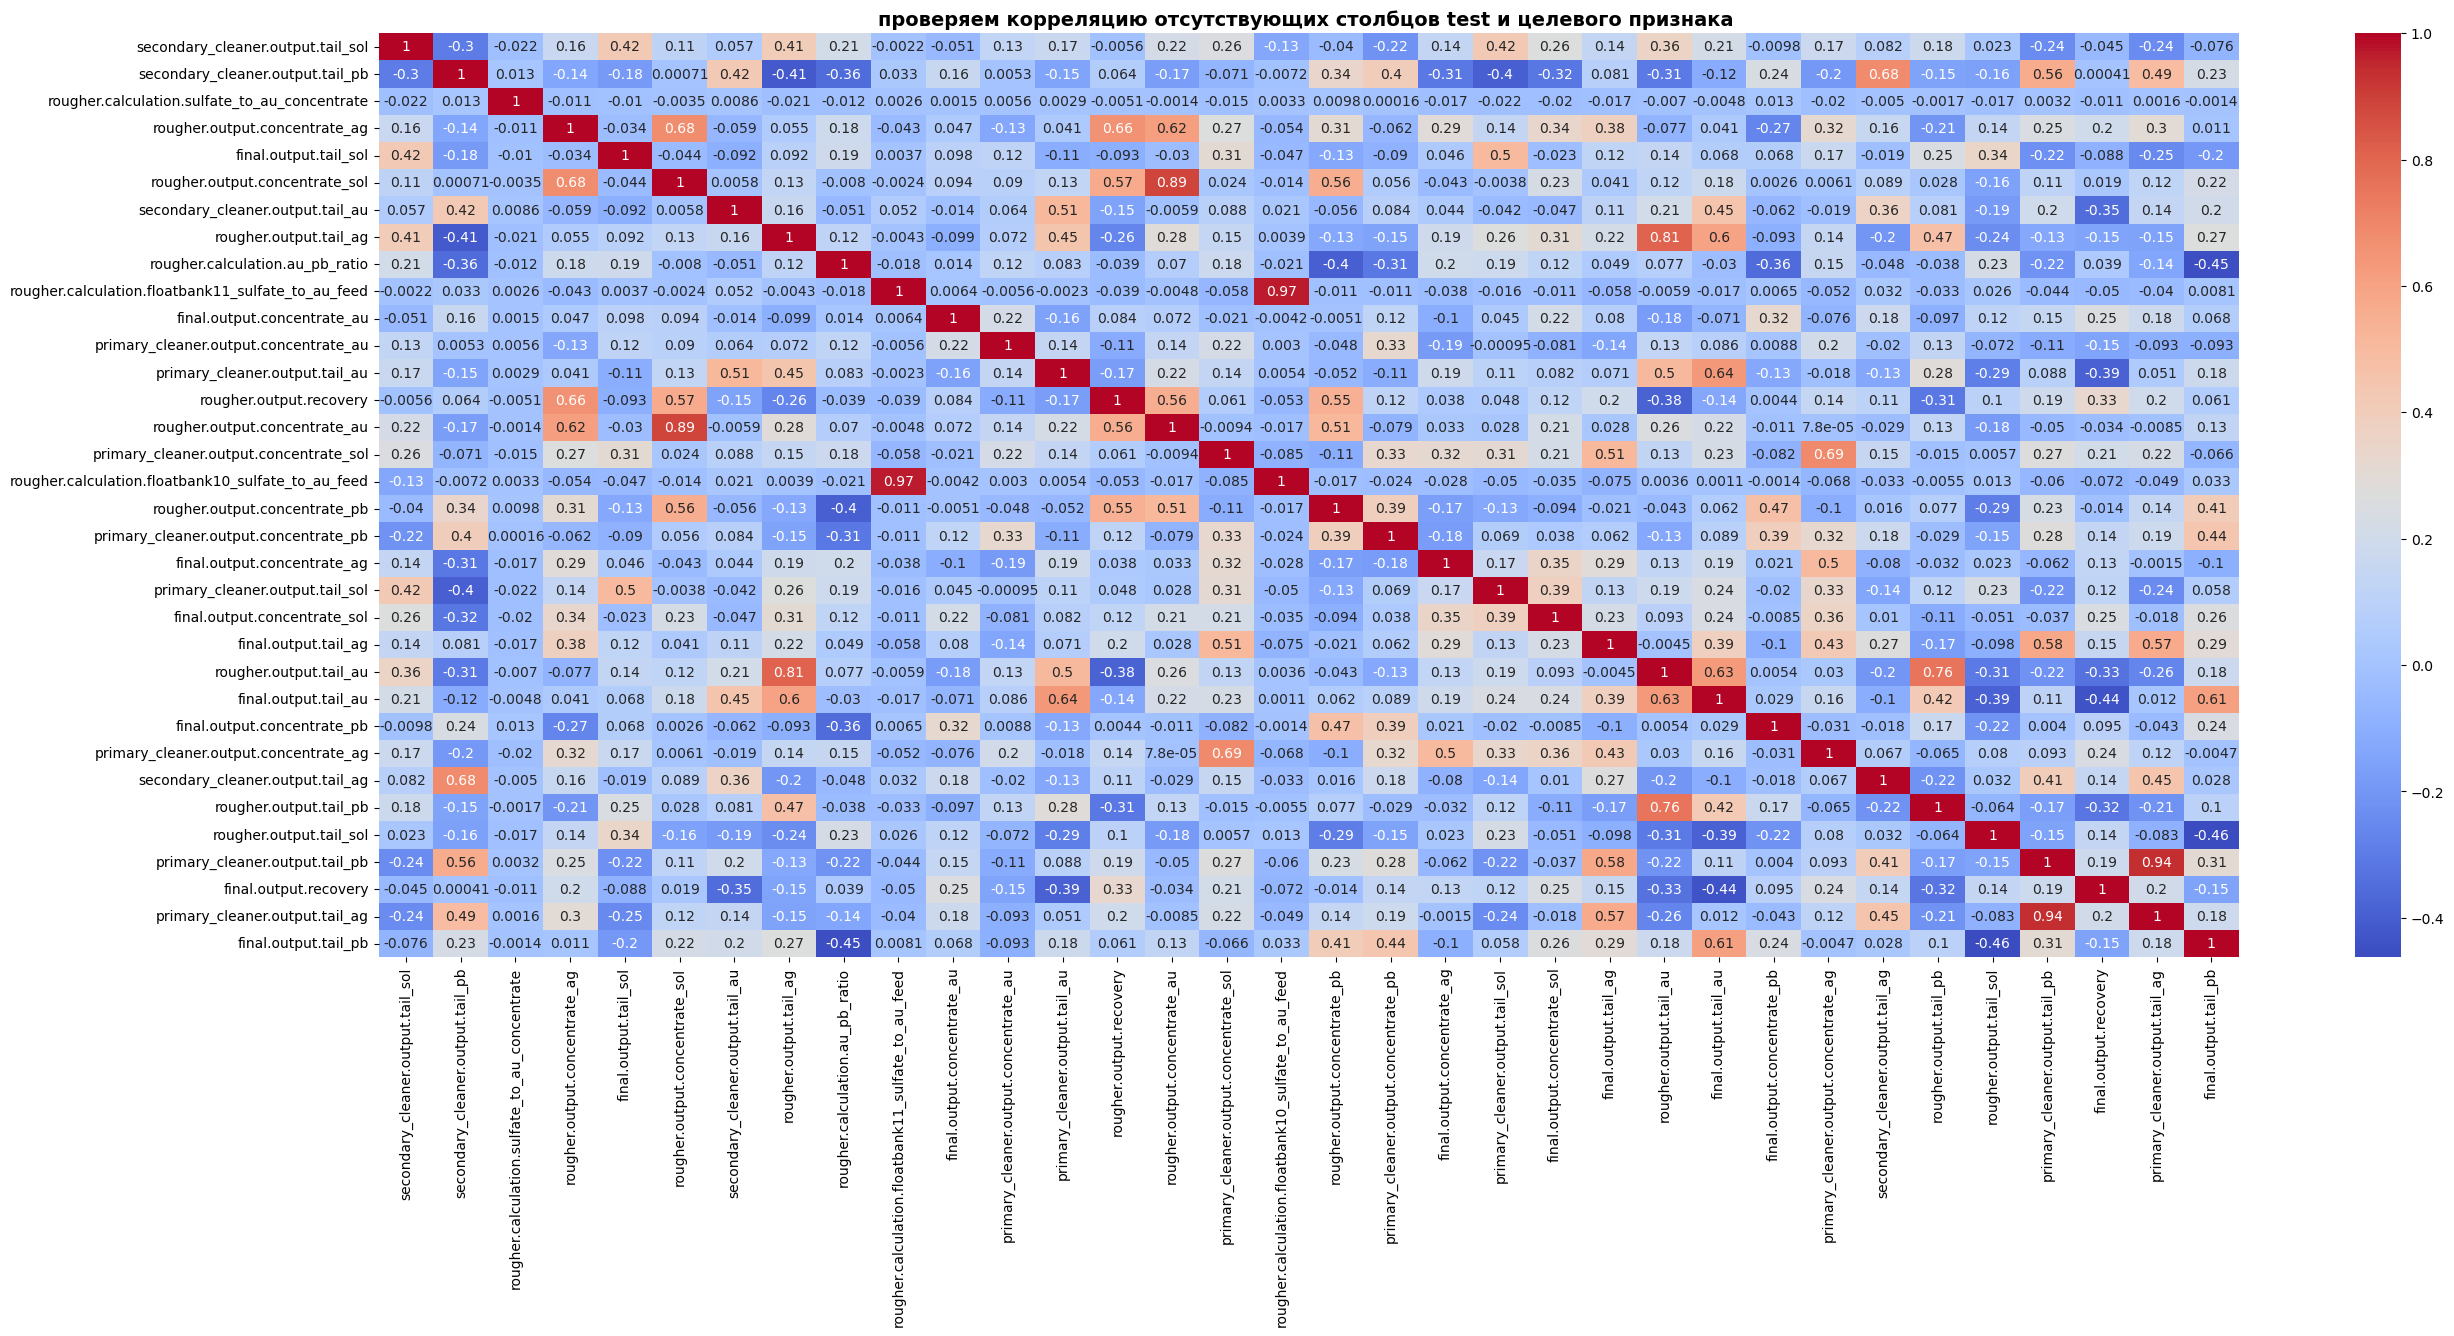

In [15]:
# проверим корреляцию отсутствующих столбцов c  final.output.recovery и rougher.output.recovery
exam_corr = data_train.loc[:][gone_columns].copy()
corr = exam_corr.corr()

plt.figure(figsize=(30, 12))
ax = sns.heatmap(data=corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True);
ax.set_title('проверяем корреляцию отсутствующих столбцов test и целевого признака ',
             dict(fontweight='bold', fontsize=14));
plt.show()

### Вывод
Отсутствующие признаки в test данных это параметры output или calculation<br>
Возможность их интерпритации наступает после флотации и очистки <br>
У целевого признака rougher.output.recovery наблюдается корреляция средней силы с признаками<br>
rougher.output.concentrate_pb, rougher.output.concentrate_au, rougher.output.concentrate_ag,<br>
rougher.output.concentrate_sol<br>
Признак final.output.recovery имеет слабую корреляцию <br>
<br>
Все отсутствующие признаки имеют характеристики целевых признаков и корреляцию средней силы с целевым признаком<br>
Поэтим причинам отсутствующие признаки не подходят для обучения модели<br>

Примем это за факт уберём из train лишние столбцы и будем работать как есть<br>

## Проверим пропуски

In [16]:
# сравним данные в trein и full
data_train.describe(include='all').isin(
    data_full.loc[data_train.index].describe(include='all')).value_counts().to_frame()

0
final.output.concentrate_ag final.output.concentrate_pb final.output.concentrate_sol final.output.concentrate_au final.output.recovery final.output.tail_ag final.output.tail_pb final.output.tail_sol final.output.tail_au primary_cleaner.input.sulfate primary_cleaner.input.depressant primary_cleaner.input.feed_size primary_cleaner.input.xanthate primary_cleaner.output.concentrate_ag primary_cleaner.output.concentrate_pb primary_cleaner.output.concentrate_sol primary_cleaner.output.concentrate_au primary_cleaner.output.tail_ag primary_cleaner.output.tail_pb primary_cleaner.output.tail_sol primary_cleaner.output.tail_au primary_cleaner.state.floatbank8_a_air primary_cleaner.state.floatbank8_a_level primary_cleaner.state.floatbank8_b_air primary_cleaner.state.floatbank8_b_level primary_cleaner.state.floatbank8_c_air primary_cleaner.state.floatbank8_c_level primary_cleaner.state.floatbank8_d_air primary_cleaner.state.floatbank8_d_level rougher.calculation.sulfate_to_au_concentrate rougher.calculation.floatbank10_sulfate_to_au_feed rougher.calculation.floatbank11_sulfate_to_au_feed rougher.calculation.au_pb_ratio rougher.input.feed_ag rougher.input.feed_pb rougher.input.feed_rate rougher.input.feed_size rougher.input.feed_sol rougher.input.feed_au rougher.input.floatbank10_sulfate rougher.input.floatbank10_xanthate rougher.input.floatbank11_sulfate rougher.input.floatbank11_xanthate rougher.output.concentrate_ag rougher.output.concentrate_pb rougher.output.concentrate_sol rougher.output.concentrate_au rougher.output.recovery rougher.output.tail_ag rougher.output.tail_pb rougher.output.tail_sol rougher.output.tail_au rougher.state.floatbank10_a_air rougher.state.floatbank10_a_level rougher.state.floatbank10_b_air rougher.state.floatbank10_b_level rougher.state.floatbank10_c_air rougher.state.floatbank10_c_level rougher.state.floatbank10_d_air rougher.state.floatbank10_d_level rougher.state.floatbank10_e_air rougher.state.floatbank10_e_level rougher.state.floatbank10_f_air rougher.state.floatbank10_f_level secondary_cleaner.output.tail_ag secondary_cleaner.output.tail_pb secondary_cleaner.output.tail_sol secondary_cleaner.output.tail_au secondary_cleaner.state.floatbank2_a_air secondary_cleaner.state.floatbank2_a_level secondary_cleaner.state.floatbank2_b_air secondary_cleaner.state.floatbank2_b_level secondary_cleaner.state.floatbank3_a_air secondary_cleaner.state.floatbank3_a_level secondary_cleaner.state.floatbank3_b_air secondary_cleaner.state.floatbank3_b_level secondary_cleaner.state.floatbank4_a_air secondary_cleaner.state.floatbank4_a_level secondary_cleaner.state.floatbank4_b_air secondary_cleaner.state.floatbank4_b_level secondary_cleaner.state.floatbank5_a_air secondary_cleaner.state.floatbank5_a_level secondary_cleaner.state.floatbank5_b_air secondary_cleaner.state.floatbank5_b_level secondary_cleaner.state.floatbank6_a_air secondary_cleaner.state.floatbank6_a_level   
True                        True                        True                         True                        True                  True                 True                 True                  True                 True                          True                             True                            True                           True                                  True                                  True                                   True                                  True                           True                           True                            True                           True                                   True                                     True                                   True                                     True                                   True                                     True                                   True                                     True                                          True                                               True                            

In [17]:
# посмотрим на признаки с различиями
exam1 = data_full.loc[data_train.index]['primary_cleaner.state.floatbank8_a_air'].describe() == data_train[
    'primary_cleaner.state.floatbank8_a_air'].describe()
exam2 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_air'].describe() == data_train[
    'secondary_cleaner.state.floatbank2_b_air'].describe()
exam3 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_level'].describe() == data_train[
    'secondary_cleaner.state.floatbank2_b_level'].describe()
exam4 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank5_a_air'].describe() == data_train[
    'secondary_cleaner.state.floatbank5_a_air'].describe()
exam_equal = pd.concat([exam1, exam2, exam3, exam4], axis=1)
display(exam_equal)

,primary_cleaner.state.floatbank8_a_air,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank5_a_air
count,True,True,True,True
mean,True,True,True,True
std,False,True,True,True
min,True,True,True,True
25%,True,True,True,False
50%,True,True,True,True
75%,True,False,True,True
max,True,True,False,True


In [18]:
# сравним суммы столбцов с различиями в описании
exam1 = data_full.loc[data_train.index]['primary_cleaner.state.floatbank8_a_air'].sum() == data_train[
    'primary_cleaner.state.floatbank8_a_air'].sum()
exam2 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_air'].sum() == data_train[
    'secondary_cleaner.state.floatbank2_b_air'].sum()
exam3 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_level'].sum() == data_train[
    'secondary_cleaner.state.floatbank2_b_level'].sum()
exam4 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank5_a_air'].sum() == data_train[
    'secondary_cleaner.state.floatbank5_a_air'].sum()

if exam1 == exam2 == exam3 == exam4:
    print(f'Суммы в столбцах в которых наблюдались различия равны.')
else:
    print(f'Суммы в столбцах в которых наблюдались различия не равны.')

Суммы в столбцах в которых наблюдались различия равны.


Видим, что данные в train и full полностью совпадают<br>
Различия в столбцах<br>
primary_cleaner.state.floatbank8_a_air<br>
secondary_cleaner.state.floatbank2_b_air<br>
secondary_cleaner.state.floatbank2_b_level<br>
secondary_cleaner.state.floatbank5_a_air<br>
Не значительные, можем предположить, что получились в результате округления<br>


In [19]:
# сравним данные в test и full
data_test.describe(include='all').isin(data_full.loc[data_test.index].describe(include='all')).value_counts().to_frame()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,
True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,8


Данные data_full и data_test равны<br>
Убедились, что данные train и test принадлежат data_frame full

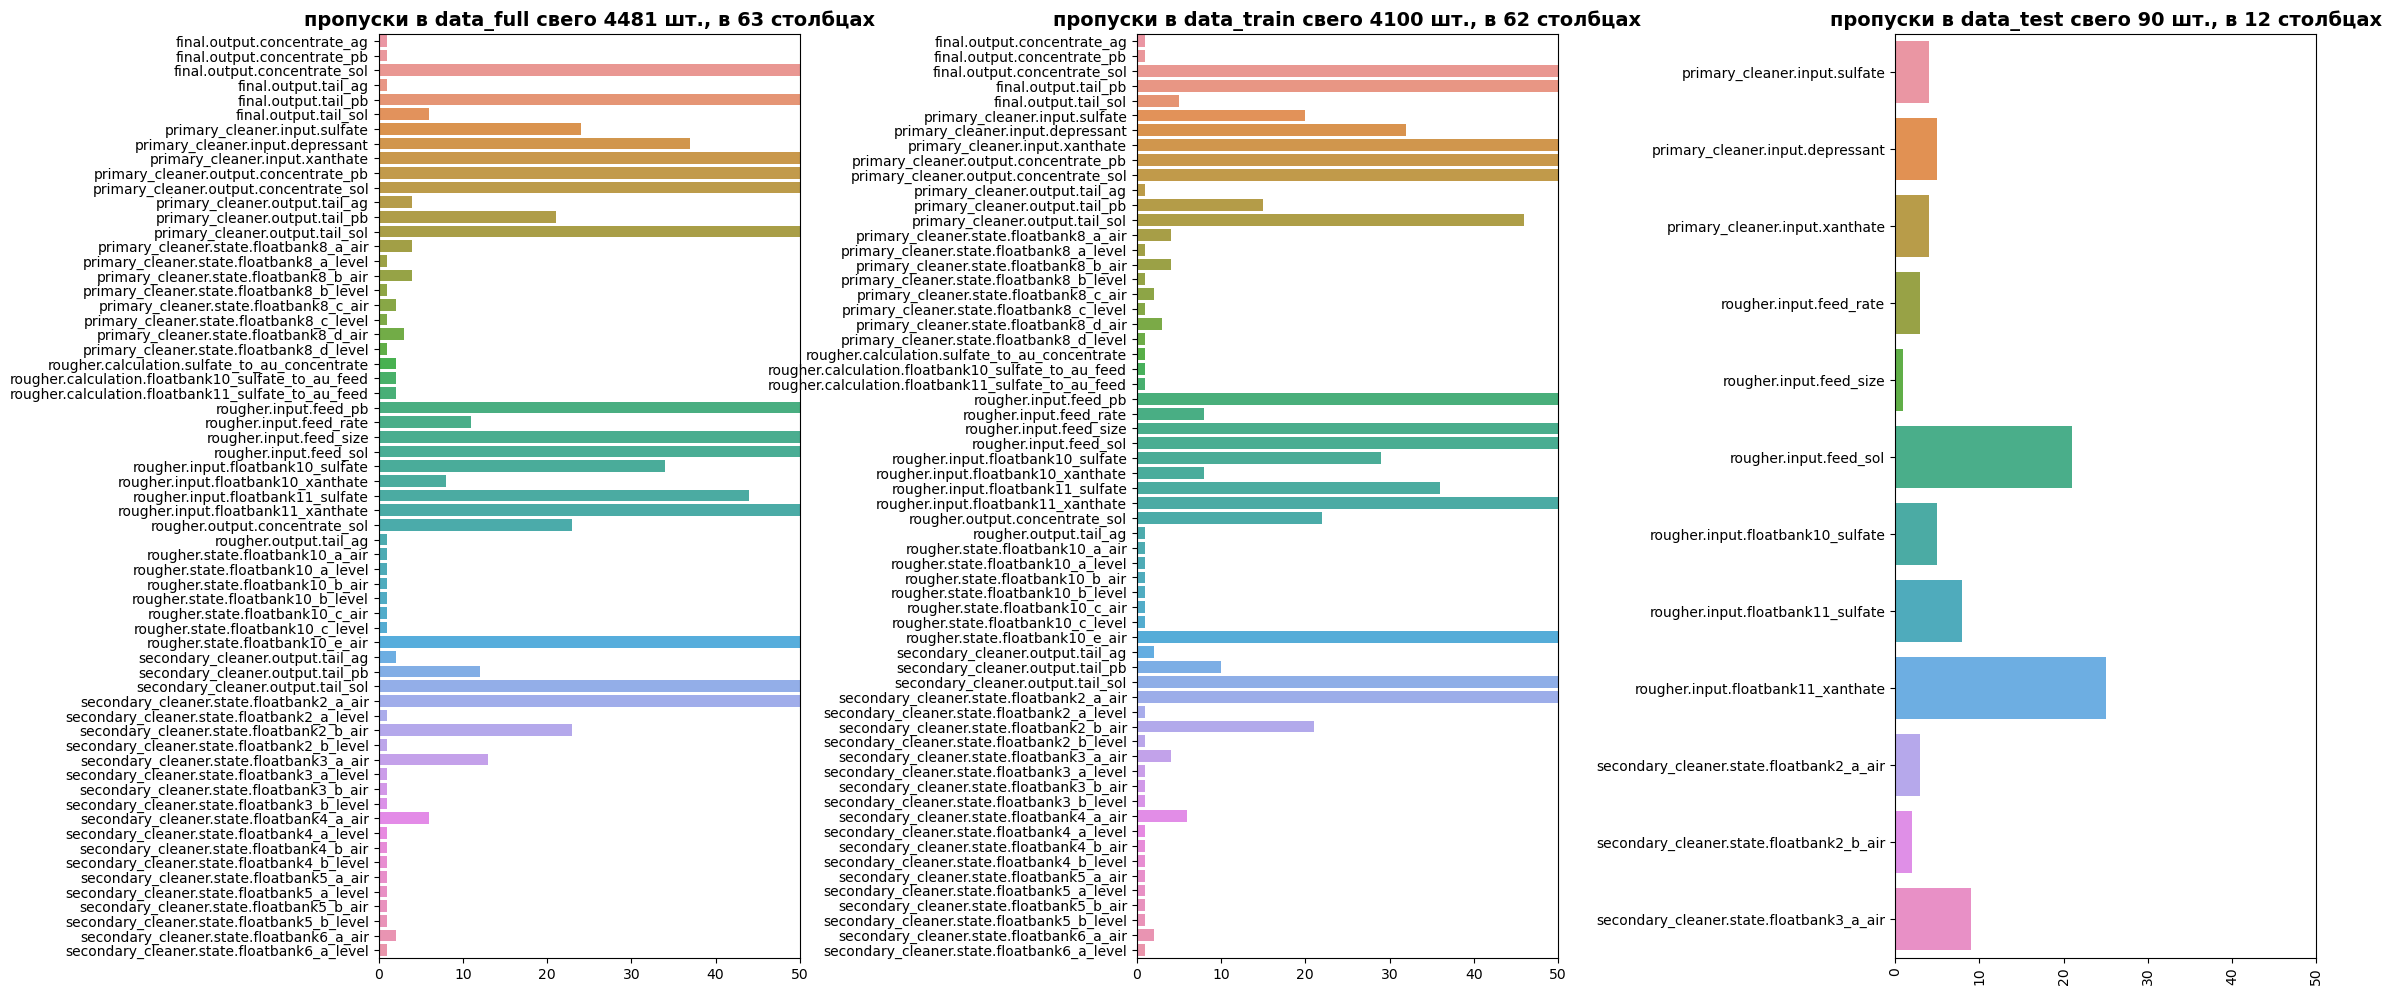

In [20]:
# проверим пропуски и создадим графическое изображение для сравнения
exam_full = data_full.isna().sum() > 0
exam_full = pd.DataFrame(data_full.isna().sum()[exam_full]).T

exam_train = data_train.isna().sum() > 0
exam_train = pd.DataFrame(data_train.isna().sum()[exam_train]).T

exam_test = data_test.isna().sum() > 0
exam_test = pd.DataFrame(data_test.isna().sum()[exam_test]).T

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 12));
plt.subplots_adjust(wspace=0.8, hspace=0.5)
full = (sns.barplot(data=exam_full, orient='h', ax=ax1).set_title(
    'пропуски в data_full свего {} шт., в {} столбцах'.format(exam_full.values.sum(), len(exam_full.T)),
    dict(fontweight='bold', fontsize=14)));
axes = full.axes.set(xlim=(0, 50));

train = (sns.barplot(data=exam_train, orient='h', ax=ax2).set_title(
    'пропуски в data_train свего {} шт., в {} столбцах'.format(exam_train.values.sum(), len(exam_train.T)),
    dict(fontweight='bold', fontsize=14)));
axes = train.axes.set(xlim=(0, 50));

test = (sns.barplot(data=exam_test, orient='h', ax=ax3).set_title(
    'пропуски в data_test свего {} шт., в {} столбцах'.format(exam_test.values.sum(), len(exam_test.T)),
    dict(fontweight='bold', fontsize=14)));
axes = test.axes.set(xlim=(0, 50));

plt.xticks(rotation=90);

Посмотрели на пропуски, везде есть <br>
В описании сказано, что значения признаков расположенных рядом близки <br>
Заполним пропуски в data_full значениями расположенными рядом <br>
Затем поделим на train и test выборку соблюдая пропорции которые есть <br>
И наминал столбцов test выборки

In [21]:
# проверим наличие пропусков в последней строке
isna_last_row = data_full[data_full.columns][-1:].values
if np.isnan(isna_last_row[0]).sum() > 0:
    print('В последней строчке есть пропуски и надо их заполнить в первую очередь')
else:
    print('В последней строчке нет пропусков, можно реализовывать заполнение подстановкой близко стоящим значением')


В последней строчке нет пропусков, можно реализовывать заполнение подстановкой близко стоящим значением


In [22]:
%%time
isna_data_full = data_full.copy()
isna_data_full = isna_data_full.fillna(method='bfill', axis=0)

CPU times: user 13 ms, sys: 9.24 ms, total: 22.2 ms
Wall time: 131 ms


In [23]:
# проверим заполнение
display(isna_data_full.describe())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,...,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000
mean,5.168382,9.978817,9.441265,44.076513,67.050208,9.688356,2.694390,10.582984,3.042467,144.502167,...,18.985683,-485.897735,15.010210,-461.083174,15.694166,-488.684070,12.198006,-487.150492,18.958457,-505.441087
std,1.372368,1.669232,2.849194,5.129784,10.125840,2.328808,0.959863,2.868807,0.922808,44.624552,...,5.411424,47.759450,4.890150,67.406760,5.510977,34.532507,5.332973,38.346438,5.550513,37.693984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251000,9.137225,7.674529,43.402215,63.299712,8.062715,2.027553,8.938662,2.461138,113.990977,...,14.975304,-500.705070,11.940333,-500.187767,10.988528,-500.458409,8.971074,-500.129455,14.983005,-500.728189
50%,5.066039,10.102264,9.193185,45.011244,68.172738,9.743106,2.743965,10.622340,2.984909,143.154076,...,18.017317,-499.837795,14.970988,-499.459790,14.999920,-499.802570,11.019389,-499.935338,19.960511,-500.048424
75%,5.895401,11.035644,10.925465,46.275313,72.686642,11.134242,3.329206,12.103709,3.571351,175.014449,...,23.012460,-498.249814,19.034114,-400.118175,18.026184,-498.383889,14.019040,-499.437546,24.002617,-499.495403
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


### Вывод
Пропуски присутствуют во всех дата фреймах, их природа не ясна<br>
Подтвердили, что data_train  и data_test являются выборками из data_full <br>
Поскольку значения расположенные рядом часто похожи, по условию<br>
Заменили пропуски в data_full близ лежащими значениями<br>
Пропуски в остальных дата фреймах обрабатывать не стали<br>
Потому, что мы их создадим заново из data_full

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Интересный способ обработки пропусков через `full` с последующим сплитованием выборок - тут всё хорошо.

## Воссоздание train и test выборки

Исходя из того, что train и test выборки это поделённый data_full <br>
Воссоздадим наборы train и test заново из подготовленного isna_data_full<br>
Соблюдая пропорции и наминал признаков test выборки<br>

In [24]:
# определим размер тестовой выборки
size_test_data = len(data_test)/len(data_full)
print(f'Размер тестовой выбореи равен {size_test_data:.2%}')

Размер тестовой выбореи равен 27.21%


In [25]:
# создадим датафрейт с признаками test выборки + целевые признаки
def new_data_full(data):
    new_full = data[TEST_COLUMNS].copy()
    # напилим выборок для работы
    features = new_full.drop(columns=TARGET, axis=1).copy()
    target = new_full[TARGET].copy()
    X_feat, X_valid, y_feat, y_valid = (train_test_split(features, target, test_size=.2721, \
                                                         random_state=RANDOM_STATE))
    # масштабируем полученные признаки
    scaler = StandardScaler().fit(X_feat)

    X_feat_ss = pd.DataFrame(scaler.transform(X_feat), index=X_feat.index, columns=features.columns)
    X_valid_ss = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=features.columns)
    return X_feat, X_valid, y_feat, y_valid, X_feat_ss, X_valid_ss

In [26]:
# поделим на выборки по новому
X_feat, X_valid, y_feat, y_valid, X_feat_ss, X_valid_ss = new_data_full(isna_data_full)


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Повторно разделили выборки на `train` и `test` - отлично!

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выполнили стандартизацию непрерывных признаков - отлично!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь заканчивается стрктурный блок работы - стоит делать промежуточные выводы о проделанной работе, это довольно полезная практика, которая имеет большую ценность для получателя отчёта.
        
Достаточно будет двух-трёх тезисных предложений об основных шагах и полученных выводах.
        
</div>

<div class="alert alert-info">
<h2>Поправил <a class="tocSkip"> </h2>

</div>

### Вывод: подготовка данных

В ходе подготовки данных проверили корректность расчета признака rougher.output.recovery<br>
Провели расчет по формуле и рассчитали значение SMAPE и MAE, которые подтвердили корректность <br>
Расчета показателя восстановления золота в руде<br>
<br>
Проанализировали отсутствующие признаки в тренировочных данных <br>
Это параметры output или calculation возможность их интерпретации наступает после флотации и очистки<br>
У целевого признака rougher.output.recovery наблюдается корреляция средней силы с признаками<br>
rougher.output.concentrate_pb, rougher.output.concentrate_au, rougher.output.concentrate_ag,<br>
rougher.output.concentrate_sol<br>
Признак final.output.recovery имеет слабую корреляцию<br>
Отсутствующие признаки имеют характеристики целевых признаков и корреляцию средней силы с целевым признаком<br>
По этим причинам признаки не подходят для обучения модели<br>
<br>
Пропуски присутствуют во всех дата фреймах, их природа не ясна<br>
Подтвердили, что data_train и data_test являются выборками из data_full<br>
Поскольку значения расположенные рядом часто похожи, по условию<br><br>
Заменили пропуски в data_full близ лежащими значениями<br>
Пропуски в остальных дата фреймах обрабатывать не стали<br>
Потому, что мы их создадим заново из data_full<br>

## Анализ данных

### Изменение концентрации металов (Au, Ag, Pb) на разных стадиях очистки

In [27]:
# функция принимает название металла выбирает подходящие признаки и выводит гфик концентрации металлов
def metal_concentration_graphs(metal, concentrate_colum=CONCENTRATE_METRICS):
    column = ['{}_{}'.format(x, metal) for x in CONCENTRATE_METRICS]
    mean_concentr = pd.DataFrame(data=isna_data_full[column].median(), columns=[metal])
    mean_concentr.index = CONCENTRATE_METRICS

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(25, 5))
    fig.subplots_adjust(wspace=.4)
    sns.kdeplot(data=isna_data_full[column], fill=True, common_norm=False, palette=color_pal[:4],
                alpha=.7, linewidth=2, ax=ax)
    # sns.lineplot(data=mean_concentr, linewidth=4, legend=False, ax=ax1)
    sns.boxplot(data=isna_data_full[column], ax=ax1, orient='h')

    ax.set_xlabel('concentrate', dict(fontstyle='oblique', fontweight='medium', fontsize=20, ))
    ax1.set_xlabel('concentrate', dict(fontstyle='oblique', fontweight='medium', fontsize=20, ))
    ax.set_title('концентрация {} на разных этапах очистки'.format(metal.upper()),
                 dict(fontstyle='oblique', fontweight='bold', fontsize=20));
    ax1.set_title('концентрация {} на разных этапах очистки'.format(metal.upper()),
                  dict(fontstyle='oblique', fontweight='bold', fontsize=20));
    ax.xaxis.grid(True)
    ax1.xaxis.grid(True)
    return mean_concentr


plt.show();

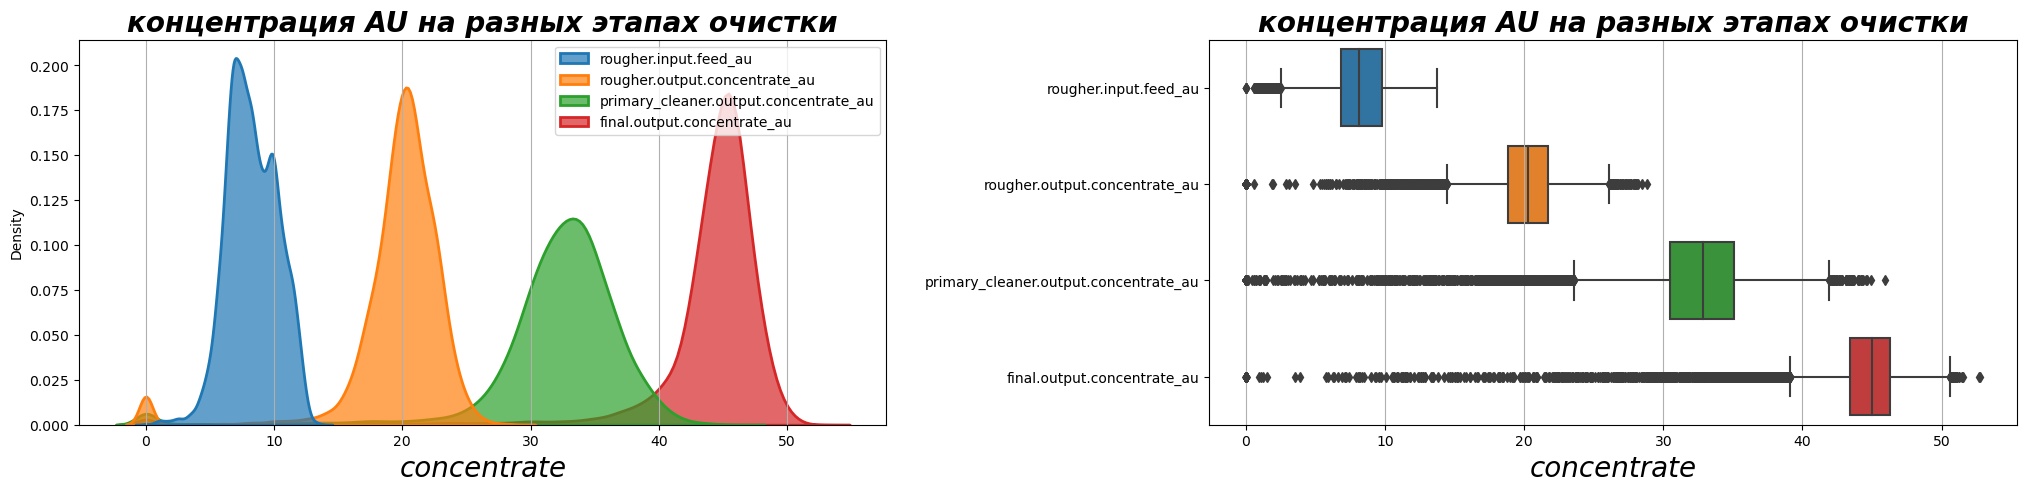

In [28]:
au_mean_concentr = metal_concentration_graphs('au');

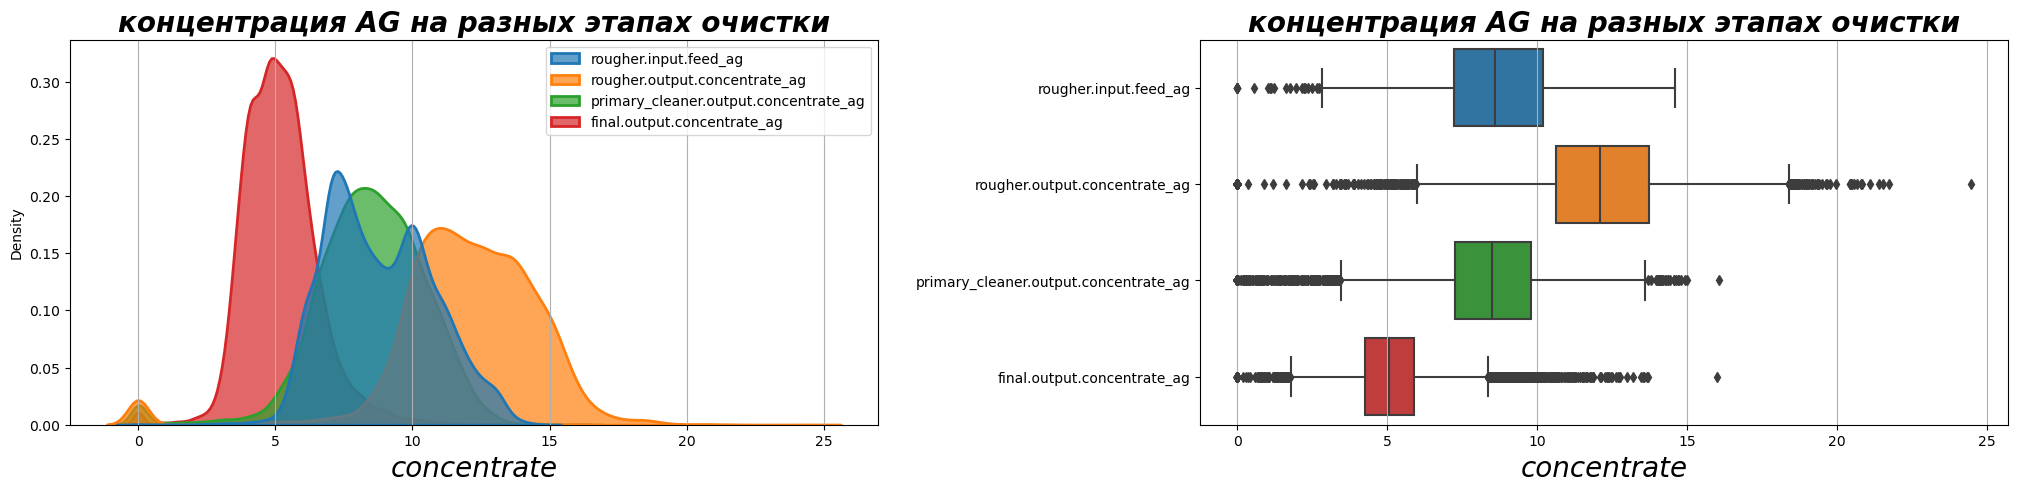

In [29]:
ag_mean_concentr = metal_concentration_graphs('ag')

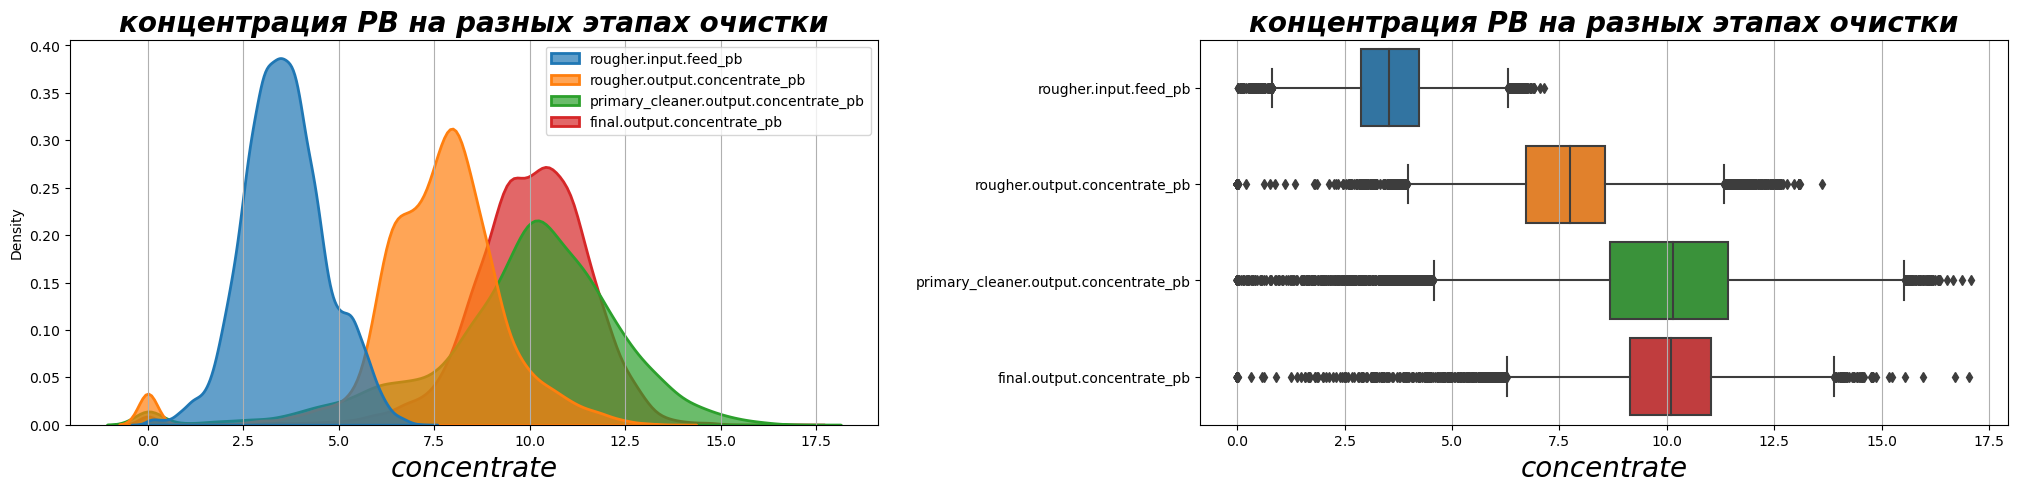

In [30]:
pb_mean_concentr = metal_concentration_graphs('pb')

In [31]:
mean_concentr_list = pd.concat([au_mean_concentr, ag_mean_concentr, pb_mean_concentr], axis=1).T
mean_concentr_list

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
au,8.125839,20.280214,32.841295,45.011244
ag,8.593574,12.098115,8.507298,5.066039
pb,3.528235,7.742580,10.140400,10.102264


#### Вывод

В процессе очистки концентрация золото (AU) увеличивается в 5.5 раза относительно первоначальной<br>
Концентрация серебра (AG) уменьшилась на 41% относительно первоначальной<br>
Концентрация свинца (PB) увеличивается в 2.8 раза относительно первоначальной<br>

Можно заметить на графиках "концентрации металлов на этапах очистки", что есть небольшое количество значений около нуля<br>
Предполагаем, что это нормально, поскольку не во всей поступающей руде есть металлы и у нас есть небольшое количество<br>
Руды концентрация металлов в которой равно нули или близко к нулю<br>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследована концентрация металлов на разных стадиях обработки, проанализирована динамика концентрации в зависимости от этапа техпроцесса - отлично, тут всё верно.

### Распределение размеров гранул сырья на обучающей и тестовой выборках

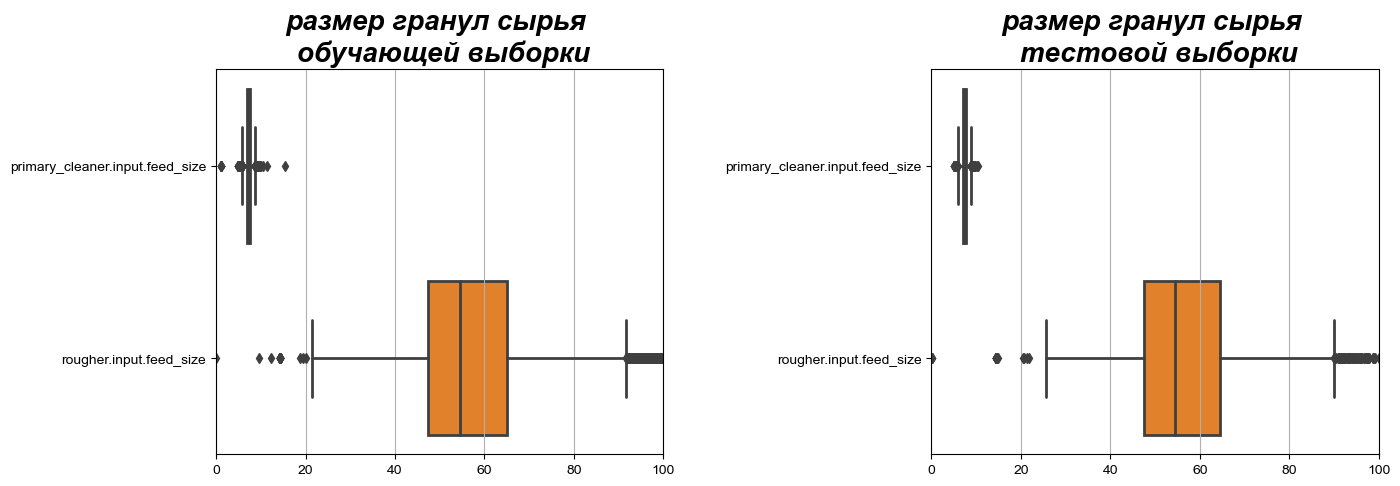

In [32]:
# сгенерируем список с признаков с размерами гранул сырья
feed_size_list = [x for x in X_feat if 'feed_size' in x]

# создадим боксплот для описания размеров гранул сырья
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=.6)

ax.set_xlim([0, 100])
ax1.set_xlim([0, 100])
sns.set_style("dark")
sns.boxplot(data=X_feat[feed_size_list], orient='h', palette=color_pal[:4], linewidth=2, ax=ax) \
    .set_title('размер гранул сырья \n обучающей выборки', dict(fontstyle='oblique', fontweight='bold', fontsize=20));
sns.boxplot(data=X_valid[feed_size_list], orient='h', palette=color_pal[:4], linewidth=2, ax=ax1) \
    .set_title('размер гранул сырья \n тестовой выборки', dict(fontstyle='oblique', fontweight='bold', fontsize=20));

ax.xaxis.grid(True)
ax1.xaxis.grid(True)

#### Вывод

Видим, что размер гранул сырья до флотации и до очистки одинаковые у тренировочной и тестовой выборки<br>
Логично, что на вход флотации поступает парода с размером гранул в широком диапазоне<br>
От 25 до 90, после флотации порода измельчается и на следующих этапах очистки размер гранул находится<br>
В меньшем диапазоне приблизительно от 5 до 15<br>
Есть маленькое количество гранул до флотации с размером около нуля, что в принципе невозможно<br>
Поэтому проверим и если есть нулевой размер гранул удалим его<br>

In [33]:
if (X_feat['rougher.input.feed_size'] <= 0).any():
    print('В обучающей выборке есть руда с размером гранул ноль или отрицательным размером')
elif (X_valid['rougher.input.feed_size'] <= 0).any():
    print('В тестовой выборке есть руда с размером гранул ноль или отрицательным размером')
else:
    print('В выборках нет руды с размером ноль или отрицательным размером гранул породы')


В выборках нет руды с размером ноль или отрицательным размером гранул породы


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Сравнили размеры гранул сырья на обучающей и тестовой выборках для этапов `rougher.input.feed_size` и `primary_cleaner.input.feed_size` - отлично, распределения между выборками действительно схожи, следовательно модель будет корректно работать.

### Суммарная концентрация всех веществ

рассмотрим концентрацию всех веществ на этапах очистки

In [34]:
# функция считает количество всех элементов на разных этапах очистки и возвращает новый датафрейм
def all_elements(data, metal, name, concentrate):
    data_hole = pd.DataFrame({name[0]:None}, index=data.index)
    for index, value in enumerate(concentrate):
        data_hole[name[index]] = pd.DataFrame(data['{}{}'.format(value, metal[0])] \
                                              + data['{}{}'.format(value, metal[1])] \
                                              + data['{}{}'.format(value, metal[2])] \
                                              + data['{}{}'.format(value, metal[3])], \
                                              columns=[name[index]],index=data.index)
        
    return data_hole.copy()

In [35]:
# посмотрим как концентрация всех элементов менялась по ходу очистки на графике
def all_elements_chart(data, name):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(25, 5))

    sns.kdeplot(data=data, fill=True, palette=color_pal[:4], ax=ax);
    sns.move_legend(ax, "upper left")
    sns.boxplot(data=data, ax=ax1)
    ax.set_title('{}'.format(name), \
                 dict(fontstyle='oblique', fontweight='bold', fontsize=20));
    ax1.set_title('{}'.format(name), \
                  dict(fontstyle='oblique', fontweight='bold', fontsize=20));



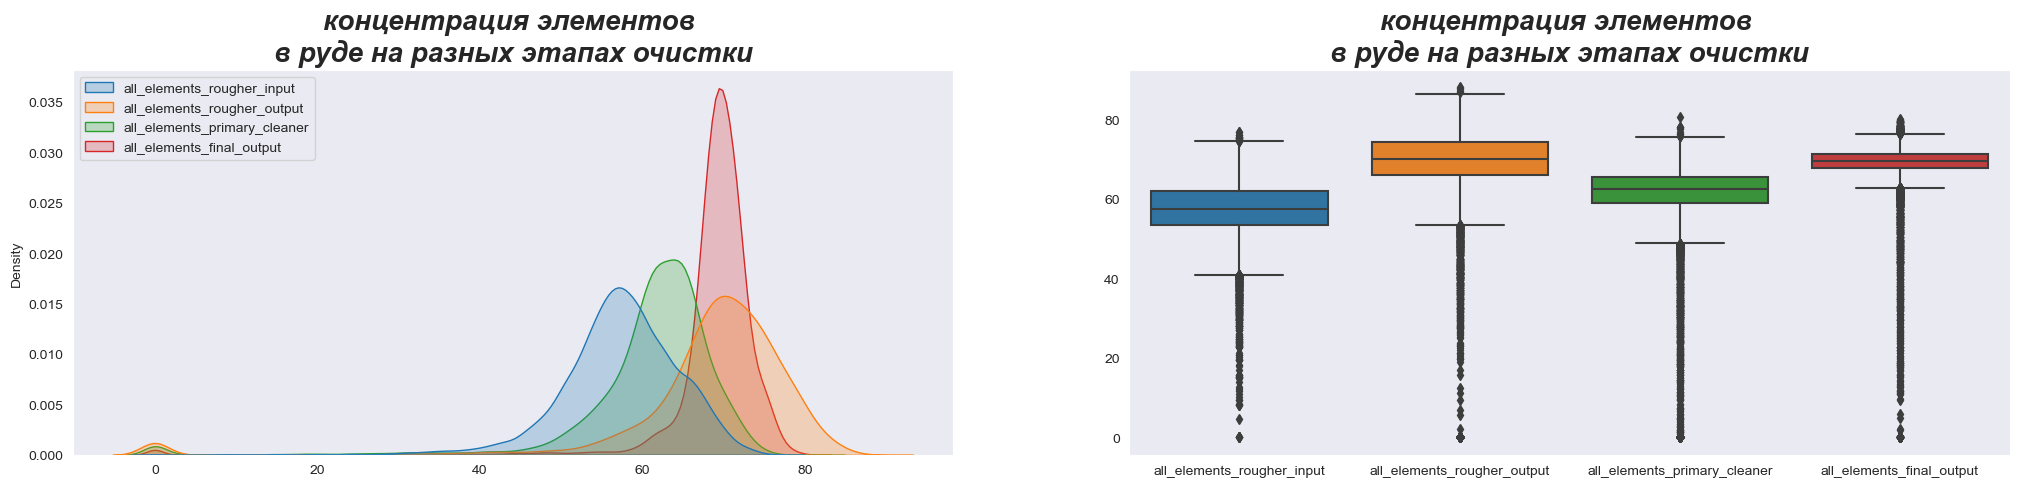

In [36]:
# объявим список с названиями элементов и список с названиями новых признаков
metal = ['_au', '_ag', '_pb', '_sol']
name = ['all_elements_rougher_input', \
    'all_elements_rougher_output', \
    'all_elements_primary_cleaner', \
    'all_elements_final_output']

data_hole = all_elements(data=isna_data_full, metal=metal, name=name, concentrate=CONCENTRATE_METRICS)
all_ruda = all_elements_chart(data=data_hole, name='концентрация элементов \nв руде на разных этапах очистки')

Видим, что в концентрации элементов на этапах очистки есть параметры выходящие за рамки ящика с усами <br>
Проверим какие из столбцов входят в признаки тестовой выборки и удалим из них выбросы<br>
В случае если таки признаки обнаружим

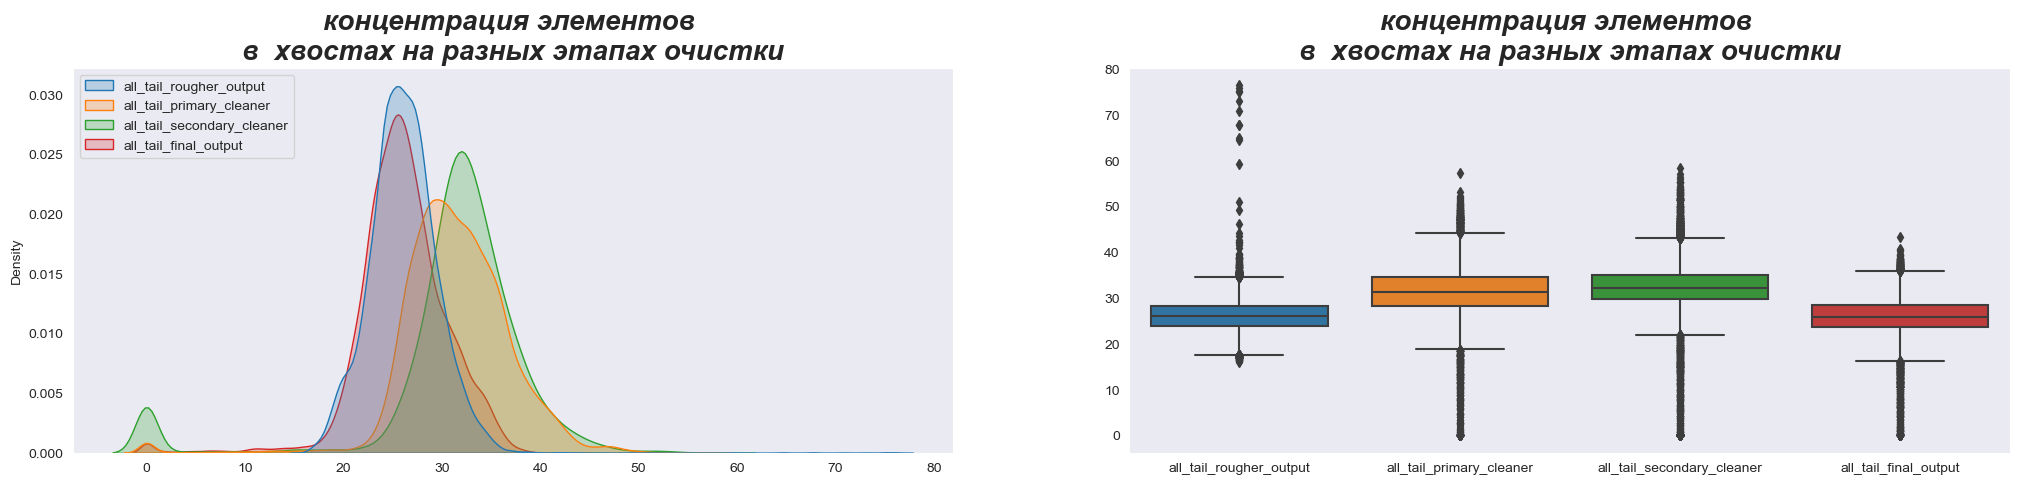

In [37]:
# объявим список с названиями элементов и список с названиями новых признаков
metal_tail = ['tail_au', 'tail_ag', 'tail_pb', 'tail_sol']
name_tail = ['all_tail_rougher_output', \
    'all_tail_primary_cleaner', \
    'all_tail_secondary_cleaner', \
    'all_tail_final_output']

data_hole_tail = all_elements(data=isna_data_full, metal=metal_tail, name=name_tail, concentrate=TAIL_METRICS)
all_tail = all_elements_chart(data=data_hole_tail, name='концентрация элементов \nв  хвостах на разных этапах очистки')

Видим, что в концентрации элементов в хвостах на этапах очистки есть параметры выходящие за рамки ящика с усами <br>
Проверим какие из признаков элементов в хвостах входят в признаки тестовой выборки и удалим из них выбросы<br>
В случае если таки признаки обнаружим

In [38]:
# проверка на вшивось 
exam = [x + i for x in CONCENTRATE_METRICS for i in ['_au', '_ag', '_pb', '_sol']]
list_elements_test_column = set(exam) - set(gone_columns)
if len(list_elements_test_column) > 0:
    print('Признаки которые присутствуют в тестовой выборке, необходимо удалить выбросы',\
                                                    'находящиеся за пределами ящика с усами')
    print(pd.Series(list(list_elements_test_column)))
else:
    print('Все признаки концентрации элементов отсутствуют в тестовой выборке')
    
print('#'*30)    

exam_tail = [x + i for x in TAIL_METRICS for i in ['tail_au', 'tail_ag', 'tail_pb', 'tail_sol']]
list_tail_elements_test_column = set(exam_tail) - set(gone_columns)
if len(list_tail_elements_test_column) > 0:
    print(pd.Series(list(list_tail_elements_test_column)))
else:
    print('Признаки элементов в хвостах отсутствуют в тестовой выборке')

Признаки которые присутствуют в тестовой выборке, необходимо удалить выбросы находящиеся за пределами ящика с усами
0     rougher.input.feed_ag
1     rougher.input.feed_pb
2    rougher.input.feed_sol
3     rougher.input.feed_au
dtype: object
##############################
Признаки элементов в хвостах отсутствуют в тестовой выборке


In [39]:
# функция размаха ящика с усами
def cut_crap(data, features):
    q1 = np.percentile(data[features], 25)
    q3 = np.percentile(data[features], 75)
    min_ = q1-(1.5*(q3-q1))
    max_ = q3+(1.5*(q3-q1))
    data = data.loc[(data[features] > min_) & (data[features] < max_)] 
    return data

In [40]:
# отправим признаки на сортировку по размаху ящика с усами
for i in list_elements_test_column:
    isna_data_full = cut_crap(isna_data_full, i)

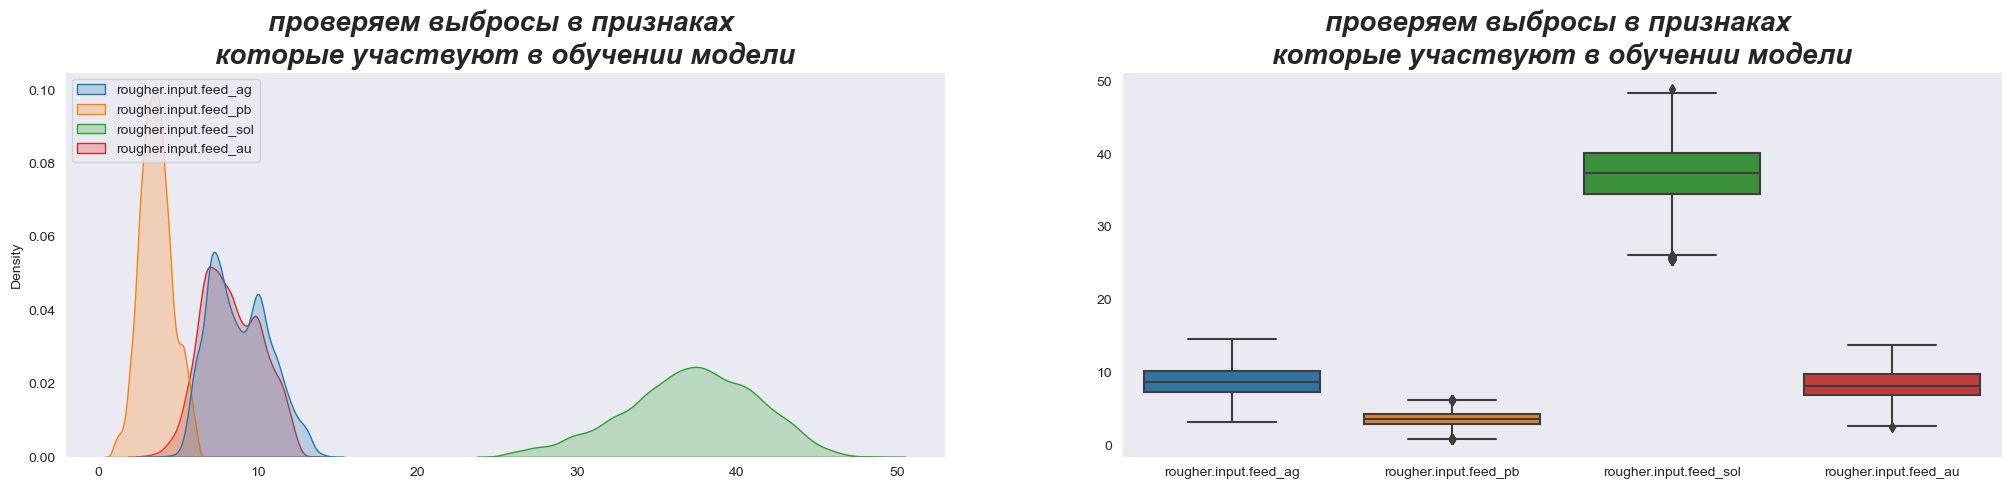

In [41]:
# проверим как сработала сортировка от выбрасов 
all_elements_chart(data=isna_data_full[list_elements_test_column],\
                   name='проверяем выбросы в признаках \nкоторые участвуют в обучении модели')

Проверим выбросы в целевых признаках

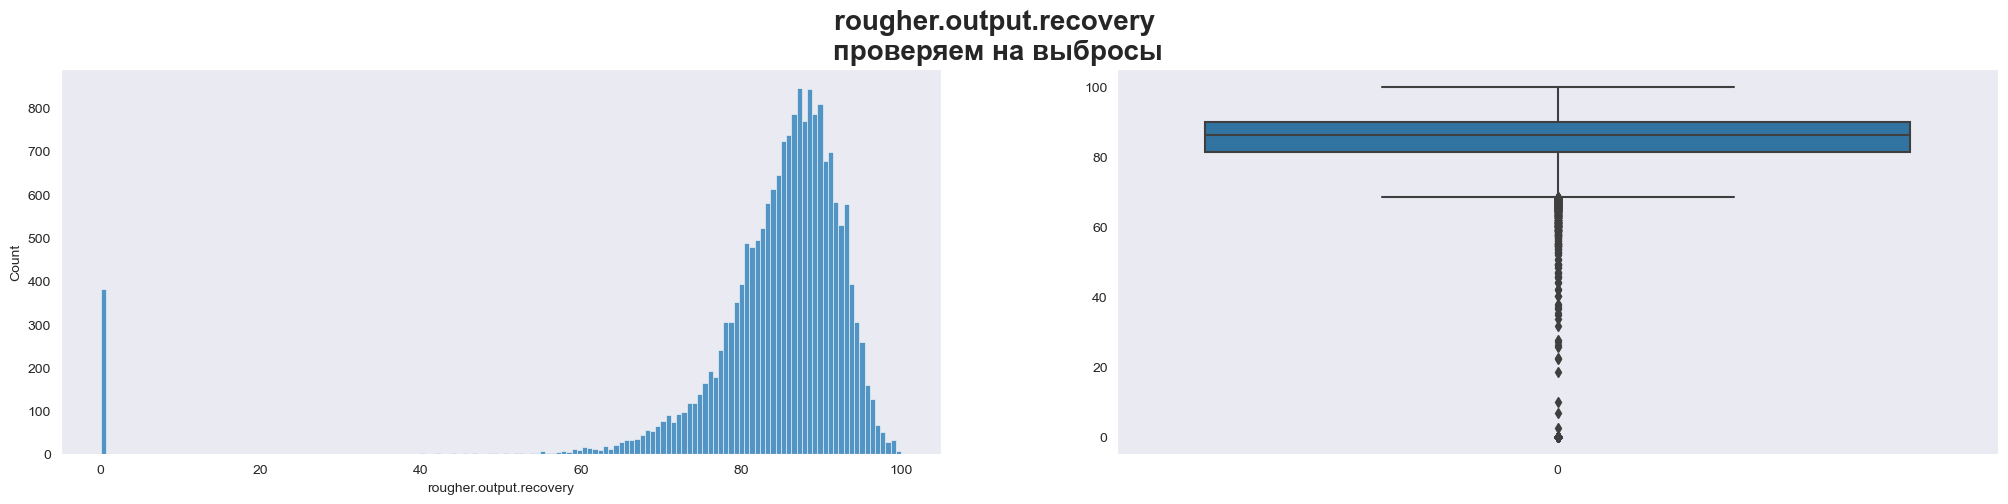

In [42]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(25, 5));
sns.histplot(data=isna_data_full[TARGET[0]], ax=ax, );
sns.boxplot(data=isna_data_full[TARGET[0]], ax=ax1, );
fig.suptitle(TARGET[0] + ' \nпроверяем на выбросы', x=0.5, y=1, fontsize=20,  fontweight='bold');

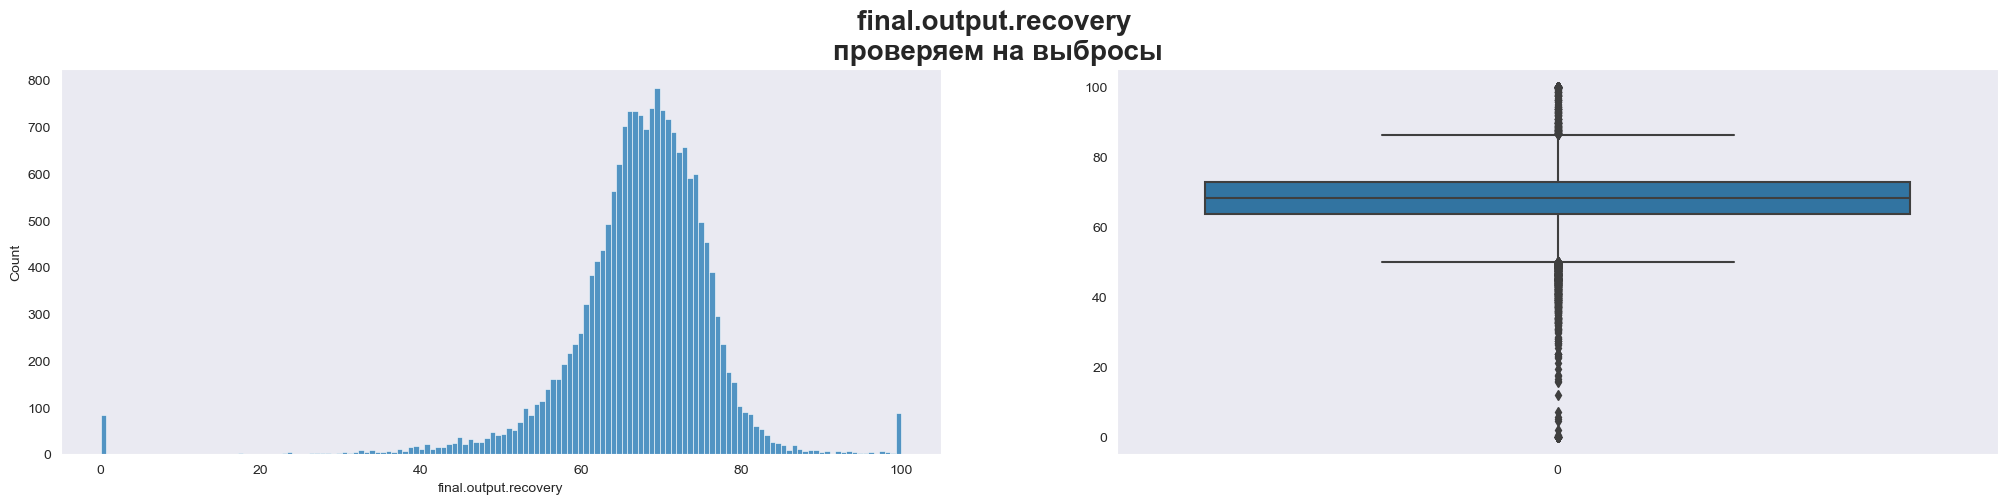

In [43]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(25, 5));
sns.histplot(data=isna_data_full[TARGET[1]], ax=ax);
sns.boxplot(data=isna_data_full[TARGET[1]], ax=ax1);
fig.suptitle(TARGET[1] + ' \nпроверяем на выбросы', x=0.5, y=1, fontsize=20,  fontweight='bold');

В обоих целевых признаках есть явные выбросы удалим их

In [44]:
# удалим выбросы из таргета
for i in TARGET:
    isna_data_full = cut_crap(isna_data_full, i)

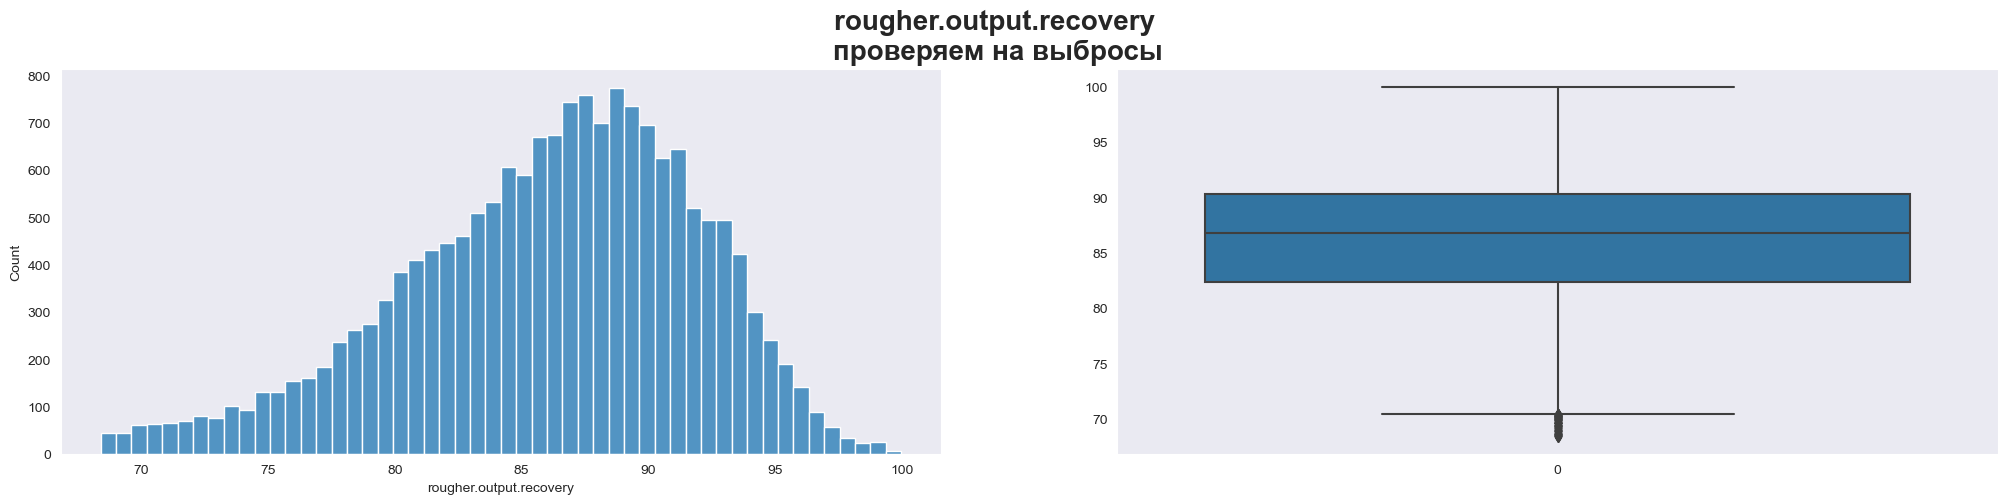

In [45]:
# проверим результат
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(25, 5));
sns.histplot(data=isna_data_full[TARGET[0]], ax=ax, );
sns.boxplot(data=isna_data_full[TARGET[0]], ax=ax1, );
fig.suptitle(TARGET[0] + ' \nпроверяем на выбросы', x=0.5, y=1, fontsize=20,  fontweight='bold');

In [46]:
# попрвавим наши выборки для дальнейшей корректной работы
X_feat, X_valid, y_feat, y_valid, X_feat_ss, X_valid_ss = new_data_full(isna_data_full)

#### Вывод
Можно отметить, что концентрация всех элементов к финалу очистки стала плотнее<br>
В начальной руде диапазон концентрации элементов находился от 40 до 75 <br>
После финальной очистки диапазон ужался и находится приблизительно от 62 до 78<br>
Это произошло вследствие того, что во время очистки пустая руда отфильтровалась<br>
<br>
Концентрация элементов в хвостах на этапах очистки, практически, не изменялась<br>
<br>
Провели фильтрацию признаков которые будут участвовать в обучении модели от выбрасов<br>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследована суммарная концентрация металлов на разных стадиях техпроцесса - отлично!

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
На данном этапе следует также избавиться от аномалий: давай обратим внимание на левую сторону графика по оси Х - все ли значения, которые мы там видим, кажутся адекватными, учитвыая, что мы анализируем суммарную концентрацию сразу четырёх веществ?

<div class="alert alert-info">
<h2>Поправил <a class="tocSkip"> </h2>
У меня была мысль сделать сортировку от выбросов, да вот некорректно проверил признаки<br>
Которые участвуют в обучении модели<br>
Поскольку концентрацию элементов мы берём из результата <br>
Который как мы установили ранее отсутствует в тестовой выборке <br>
Поэтому пропустил в первый раз<br>
<br>
Подумал, зачем удалять выбросы в признаках которые не участвуют в обучении модели)
    

</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь заканчивается стрктурный блок работы - стоит cделать промежуточные выводы о проделанной работе в блоке.

<div class="alert alert-info">
<h2>Поправил <a class="tocSkip"> </h2>

</div>

### Вывод анализ данных

Рассмотрели концентрацию металлов на разных этапах очистки<br>
В процессе очистки концентрация золото (AU) увеличивается в 5.5 раза относительно первоначальной<br>
Концентрация серебра (AG) уменьшилась на 41% относительно первоначальной<br>
Концентрация свинца (PB) увеличивается в 2.8 раза относительно первоначальной<br>
<br>
Проверили распределение гранул руды в выборках, распределение взвешенное в тренировочной и тестовой выборке<br>
<br>
Концентрация элементов в хвостах на этапах очистки, практически, не изменялась<br>
Провели фильтрацию признаков которые будут участвовать в обучении модели от выбросов<br>
Отфильтровали выбросы в таргетах

## Модель

напишем фенкцию для расчета финального SMAPE
<br>
<img src='https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg' width="600" height="150">

In [47]:
# считаем sMape
def smape(past_recovery, model_recovery):
    sMape = 100/len(past_recovery) \
            *np.sum(2*np.abs(model_recovery - past_recovery)/(np.abs(past_recovery) + np.abs(model_recovery)))
    return sMape

# sMape для модели с мультитаргетом
def final_smape_multi(roughert, final):
    rougher_output_recovery = roughert['rougher.output.recovery']
    final_output_recovery = roughert['final.output.recovery']

    sMape_rougher = smape(past_recovery=rougher_output_recovery, model_recovery=final[:, 0])
    sMape_final = smape(past_recovery=final_output_recovery, model_recovery=final[:, 1])
    s_final_mape = (.25*sMape_rougher) + (.75*sMape_final)

    return s_final_mape

# sMape для модели с одним таргетом
def final_smape_simple(roughert, final):
    sMape_simple = smape(past_recovery=roughert, model_recovery=final)
    s_final_mape = sMape_simple

    return s_final_mape

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть функции для частного и взвешенного `sMAPE` - супер!
</div>

In [48]:
# объявим коллекцию для сохранения результатов
table_sMape = pd.DataFrame({'LinearRegression':None, 'RandomForestRegressor':None, 'DecisionTreeRegressor':None}, \
                           index=['multi_target', 'rougher.output.recovery', 'final.output.recovery', \
                                                                's_final_mape']).reset_index()


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Сделали контейнер для хранения результатов моделей - отлично!
</div>

### LinearRegression

In [49]:
%%time
# линейная регресия с мульти таргетом
smape_scorer = make_scorer(final_smape_multi, greater_is_better=False)

model_lr = LinearRegression()
lr_multi_target = cross_val_score(model_lr, X_feat_ss, y_feat, \
                                  cv=5, scoring=smape_scorer, n_jobs=-1).mean()

print('Финальный sMAPE для линейной регрессии и мультитаргете: {:.3f}'.format(np.abs(lr_multi_target)))

Финальный sMAPE для линейной регрессии и мультитаргете: 5.235
CPU times: user 36.9 ms, sys: 62.5 ms, total: 99.4 ms
Wall time: 3.1 s


In [50]:
%%time
# линейная регресия с одним таргетом
smape_sco = make_scorer(final_smape_simple)
ror_simple_target_lr = cross_val_score(model_lr, X_feat_ss, y_feat['rougher.output.recovery'],\
                                       cv=5, scoring=smape_sco,  n_jobs=-1).mean()


# линейная регресия с одним таргетом
for_simple_target_lr = cross_val_score(model_lr, X_feat_ss, y_feat['final.output.recovery'],\
                                       cv=5, scoring=smape_sco,  n_jobs=-1).mean()

s_final_mape_lr = (.25*ror_simple_target_lr) + (.75*for_simple_target_lr)

print('sMAPE для линейной регрессии для rougher.output.recovery: {:.3f}'.format(np.abs(ror_simple_target_lr)))
print('sMAPE для линейной регрессии для final.output.recovery: {:.3f}'.format(np.abs(for_simple_target_lr)))
print('Финальный sMAPE линейной регрессии для однотаргетовых моделей: {:.3f}'.format(np.abs(s_final_mape_lr)))

sMAPE для линейной регрессии для rougher.output.recovery: 3.571
sMAPE для линейной регрессии для final.output.recovery: 5.790
Финальный sMAPE линейной регрессии для однотаргетовых моделей: 5.235
CPU times: user 30.9 ms, sys: 10.6 ms, total: 41.5 ms
Wall time: 544 ms


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Параметр `greater_is_better` у пользовательского скорринга настроен неверно: так как метрика `sMAPE` применяется для задач регрессии, то она тем лучше, чем ниже - это нужно учитывать при создании скорринга для кросс-валидации, так как по умолчанию инструменты кросс-валидации вроде `cross_val_score` и `GridSearchCV/RandomizedSearchCV` умеют только максимизировать метрику качества. Поэтому при создании скорринга с помощью `make_scorer` важно настроить параметр `greater_is_better=False`, чтобы оптимизируемая метрика минимизировалась, а не максимизировалась - таким образом задача максимизации будет решаться через задачу минимизации обратной функции.
    
Также при настройке этого параметра получаемая метрика будет отрицательной: это особеность работы `make_scorer` с настроенным параметром `greater_is_better=False`. Поэтому при выводе метрики на экран её стоит сделать положительной: взять по модулю, домножить на `-1` или просто указать `-` при выводе на экран, вроде `print(-a)`.
        
</div>

<div class="alert alert-info">
<h2>Поправил <a class="tocSkip"> </h2>

</div>

In [51]:
# заполняем таблицу значениями скоринга
table_sMape.at[0, 'LinearRegression'] = np.abs(lr_multi_target)
table_sMape.at[1, 'LinearRegression'] = ror_simple_target_lr
table_sMape.at[2, 'LinearRegression'] = for_simple_target_lr
table_sMape.at[3, 'LinearRegression'] = s_final_mape_lr

#### Результат
В момент написания финальная  sMape у LinearRegression с двойным таргетом идентична финальной ошибки для <br>
моделей с одним таргетом <br>


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Оценили линейную регрессию на кросс-валидации - отлично! 
    
Хороший пример того, что способ предсказания таргета - по отдельности или сразу - не влияет на качество модели.
    
При работе с `cross_val_score`, а также с `GridSearchCV` или `RandomizedSearchCV` есть несколько полезных действий, которые сделают нашу жизнь проще и лучше:)
        
1. Можно настроить параметр `n_jobs=-1`, чтобы для вычислений использовались все доступные ядра - это ускорит процесс.
2. Можно настроить параметр `verbose=10`, чтобы инструмент взаимодействовал с логом и выдавал сообщения о прогрессе обучения - так мы будем понимать, что процесс идёт, а не что, например, у нас упало ядро, и процесс завис.
3. Для кросс-валидации (параметр `cv`) вполне можно использовать и 3 фолда: мы немного потеряем в качестве, но процесс будет происходить гораздо быстрее. Для учебного проекта более чем достаточно:)

### RandomForestRegressor

перебор параметров был шире, в процессе тестирования выбраны лучшие <br>
для экономии времени в примерах ниже диапазон перебора сокращен

In [52]:
%%time
# GridSearchCV RandomForestRegressor с мульти тагретом
parameters_rfr = {'n_estimators': [x for x in range(50, 101, 10)], \
              'max_depth': [None] + [i for i in range(2, 11)],\
             'max_features': ['sqrt', 'log2'],
             'min_samples_split': [x for x in range(5, 41, 8)],
             'min_samples_leaf': [x for x in range(2, 11, 3)],
             'bootstrap':[True, False]}
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE)
metrics = make_scorer(final_smape_multi, greater_is_better=False)

search_rfr = GridSearchCV(model_rfr, parameters_rfr, cv=3, verbose=1000, scoring=metrics, n_jobs=-1)
search_rfr = search_rfr.fit(X_feat_ss, y_feat)
print('Финальное sMAPE для случайного леса: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(search_rfr.best_score_), search_rfr.best_params_))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Финальное sMAPE для случайного леса: 3.569 при значениях гиперпараметров: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
CPU times: user 10.4 s, sys: 72.8 ms, total: 10.5 s
Wall time: 18.3 s
[CV 2/3; 1/1] START bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 2/3; 1/1] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV 3/3; 1/1] START bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 3/3; 1/1] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV 1/3; 1/1] START bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split

In [53]:
%%time
# GridSearchCV RandomForestRegressor для rougher.output.recovery
parameters_rfr = {'n_estimators': [x for x in range(50, 101, 10)], \
              'max_depth': [None] + [i for i in range(2, 11)],\
             'max_features': ['sqrt', 'log2', None],\
             'min_samples_split': [x for x in range(5, 41, 8)],\
             'min_samples_leaf': [x for x in range(2, 11, 3)],\
             'bootstrap':[True, False]}
metrics_simple = make_scorer(final_smape_simple, greater_is_better=False)
ror_search_rfr = GridSearchCV(model_rfr, parameters_rfr, verbose=1000, cv=2, scoring=metrics_simple, n_jobs=-1)

ror_search_rfr = ror_search_rfr.fit(X_feat_ss, y_feat['rougher.output.recovery'])

# GridSearchCV RandomForestRegressor для final.output.recovery
parameters_rfr = {'n_estimators': [x for x in range(50, 151, 10)], \
              'max_depth': [None] + [i for i in range(2, 11)],\
             'max_features': ['sqrt', 'log2', None],\
             'min_samples_split': [x for x in range(5, 41, 8)],\
             'min_samples_leaf': [x for x in range(2, 11, 3)],\
             'bootstrap':[True, False]}
fro_search_rfr = GridSearchCV(model_rfr, parameters_rfr, cv=3, verbose=1000, scoring=metrics_simple, n_jobs=-1)
for_search_rfr = fro_search_rfr.fit(X_feat_ss, y_feat['final.output.recovery'])

s_final_mape_rfr = (.25*np.abs(ror_search_rfr.best_score_)) + (.75*np.abs(for_search_rfr.best_score_))

print('sMAPE для случайного леса rougher.output.recovery: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(ror_search_rfr.best_score_), ror_search_rfr.best_params_))
print('sMAPE для случайного леса final.output.recovery: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(for_search_rfr.best_score_), for_search_rfr.best_params_))
print('Финальный sMAPE случайного леса для однотаргетовых моделей: {:.3f}'.format(s_final_mape_rfr))

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
sMAPE для случайного леса rougher.output.recovery: 2.034 при значениях гиперпараметров: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
sMAPE для случайного леса final.output.recovery: 4.143 при значениях гиперпараметров: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Финальный sMAPE случайного леса для однотаргетовых моделей: 3.615
CPU times: user 26 s, sys: 157 ms, total: 26.2 s
Wall time: 44.9 s


In [54]:
# заполняем таблицу значениями скоринга
table_sMape.at[0, 'RandomForestRegressor'] = np.abs(search_rfr.best_score_)
table_sMape.at[1, 'RandomForestRegressor'] = np.abs(ror_search_rfr.best_score_)
table_sMape.at[2, 'RandomForestRegressor'] = np.abs(for_search_rfr.best_score_)
table_sMape.at[3, 'RandomForestRegressor'] = s_final_mape_rfr

#### Результат
Средняя и финальная шибка sMape у моделей RandomForestRegressor с одинарным таргетом меньше чем модели с двойным таргетом

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Для случайного леса оптимизировали гиперпараметры и оценили модель на кросс-валидации - отлично!

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Есть пара замечаний по сетке параметров:
1. Для гиперапараметра `n_estimators` оценивается очень короткая последовательность: во-первых, исследуется ограниченный диапазон, во-вторых, в диапазоне маленький шаг - таким образом ты рискуешь делать медленный поиск параметров в неоптимальном диапазоне. Эффективнее исследовать более широкий диапазон с бОльшим шагом между значениями.
2. Для гиперпараметра `max_depth` рассматривается последовательность из очень высоких значений: деревья с большой глубиной склонны к переобучению, а обучаются и предсказывают результат они дольше, поэтому делать их слишком глубокими не стоит - оптимальное значение почти всегда лежит в диапазоне от 2 до 9-10. Кроме того, можно попробовать значение `None` - в итоге оптимальная последовательность может выглядеть как `[None] + [i for i in range(2, 11)]`.
</div>

<div class="alert alert-info">
<h2>Поправил <a class="tocSkip"> </h2>

</div>

### DecisionTreeRegressor

In [55]:
%%time
# GridSearchCV DecisionTreeRegressor для мульти таргета
parameters = {'max_depth': [None] + [i for i in range(2, 11)]}
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
metrics_multi = make_scorer(final_smape_multi, greater_is_better=False)

search_dtr = GridSearchCV(model_dtr, parameters, cv=5, verbose=10, scoring=metrics_multi, n_jobs=-1)
search_dtr = search_dtr.fit(X_feat_ss, y_feat)
print('Финальное sMAPE для дерева решений: {:.3f} при значениях гиперпараметров: {}' \
                        .format(np.abs(search_dtr.best_score_), search_dtr.best_params_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Финальное sMAPE для дерева решений: 4.603 при значениях гиперпараметров: {'max_depth': 9}
CPU times: user 572 ms, sys: 22 ms, total: 594 ms
Wall time: 5.2 s


In [56]:
%%time
# GridSearchCV DecisionTreeRegressor для rougher.output.recovery
parameters = {'max_depth': [None] + [i for i in range(2, 11)]}
metrics_simple = make_scorer(final_smape_simple, greater_is_better=False)
ror_search_dtr = GridSearchCV(model_dtr, parameters, cv=5, verbose=10, scoring=metrics_simple, n_jobs=-1)

ror_search_dtr = ror_search_dtr.fit(X_feat_ss, y_feat['rougher.output.recovery'])

# GridSearchCV DecisionTreeRegressor для final.output.recovery
for_search_dtr = GridSearchCV(model_dtr, parameters, cv=5, verbose=20, scoring=metrics_simple, n_jobs=-1)
for_search_dtr = for_search_dtr.fit(X_feat_ss, y_feat['final.output.recovery'])

s_final_mape_dtr = (.25*np.abs(ror_search_dtr.best_score_)) + (.75*np.abs(for_search_dtr.best_score_))

print('sMAPE дерева решений rougher.output.recovery: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(ror_search_dtr.best_score_), ror_search_dtr.best_params_))
print('sMAPE дерева решений final.output.recovery: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(for_search_dtr.best_score_), for_search_dtr.best_params_))
print('Финальный sMAPE дерева решений для однотаргетовых моделей: {:.3f}'.format(s_final_mape_dtr))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
sMAPE дерева решений rougher.output.recovery: 2.718 при значениях гиперпараметров: {'max_depth': 10}
sMAPE дерева решений final.output.recovery: 5.276 при значениях гиперпараметров: {'max_depth': 9}
Финальный sMAPE дерева решений для однотаргетовых моделей: 4.637
CPU times: user 1.23 s, sys: 46.7 ms, total: 1.27 s
Wall time: 12.4 s



#### Результат
Модель DecisionTreeRegressor с мульти таргетом показала почти такой же результат<br>
Как и финальная величина скоринга моделей с одним таргетом <br>
Модель для rougher.output.recovery показала лучший sMape среди остальных

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Для дерева решений оптимизировали гиперпараметры и оценили модель на кросс-валидации - отлично!

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Тут аналогичное замечание про глубину.

<div class="alert alert-info">
<h2>Поправил <a class="tocSkip"> </h2>

</div>

In [57]:
# заполняем таблицу значениями скоринга
table_sMape.at[0, 'DecisionTreeRegressor'] = np.abs(search_dtr.best_score_)
table_sMape.at[1, 'DecisionTreeRegressor'] = np.abs(ror_search_dtr.best_score_)
table_sMape.at[2, 'DecisionTreeRegressor'] = np.abs(for_search_dtr.best_score_)
table_sMape.at[3, 'DecisionTreeRegressor'] = s_final_mape_dtr

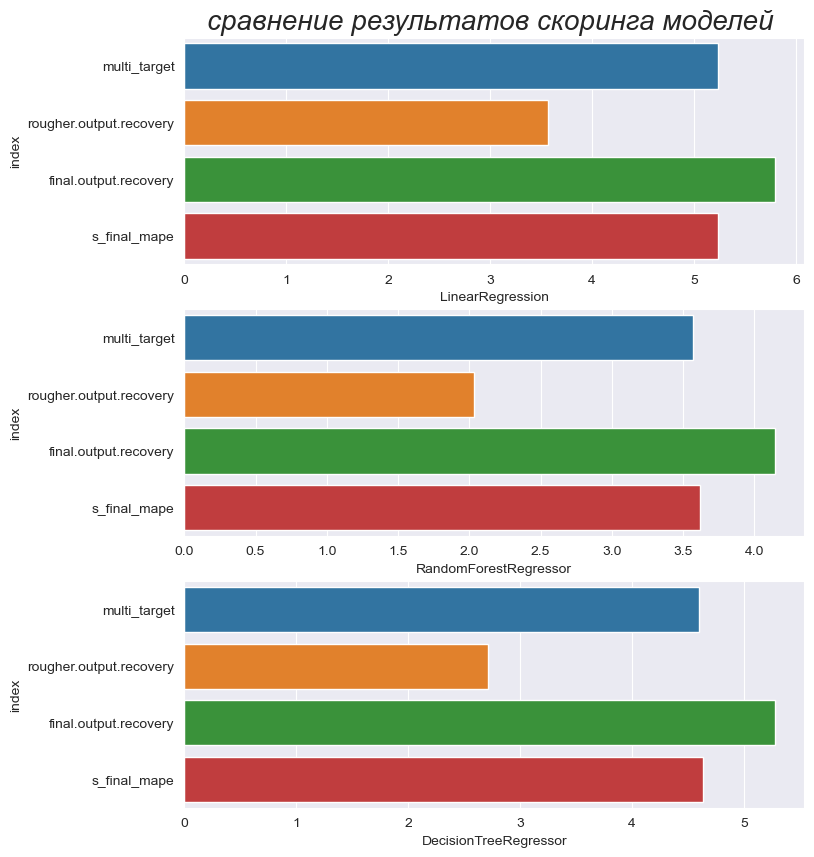

,index,LinearRegression,RandomForestRegressor,DecisionTreeRegressor
0,multi_target,5.235475,3.568981,4.603006
1,rougher.output.recovery,3.571429,2.03377,2.718015
2,final.output.recovery,5.790157,4.142511,5.276199
3,s_final_mape,5.235475,3.615326,4.636653


In [58]:
# визуальное отображение скоринга моделей
fig, (ax, ax1, ax2) = plt.subplots(3,1, figsize=(8,10))
sns.barplot(data=table_sMape, y='index', x='LinearRegression', ax=ax, orient='h')
sns.barplot(data=table_sMape, y='index', x='RandomForestRegressor', ax=ax1, orient='h');
sns.barplot(data=table_sMape, y='index', x='DecisionTreeRegressor', ax=ax2, orient='h');
ax.set_title('сравнение результатов скоринга моделей ', dict(fontstyle='oblique', fontweight='medium', fontsize=20));

ax.xaxis.grid(True)
ax1.xaxis.grid(True)
ax2.xaxis.grid(True)
plt.show()

table_sMape

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хорошая сравнительная характеристика.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Нужно сделать вывод о том, какая модель с какими гиперпараметрами была выбрана для итогового тестирования.

<div class="alert alert-info">
<h2>Поправил <a class="tocSkip"> </h2>

</div>

### Вывод

Модели выбранные для проверки на тестовых данных:
1. Модель RandomForestRegressor для признака final.output.recovery	6.209 при значениях гиперпараметров: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}

2. Модель RandomForestRegressor для признака rougher.output.recovery 6.692 при значениях гиперпараметров: {'max_depth': None}	




### Проверка на тестовой выборке

In [61]:
%%time

test_model_dtr = RandomForestRegressor(n_estimators=100, max_depth=None, \
                                       max_features='sqrt', min_samples_leaf=2,\
                                       min_samples_split=5, bootstrap=False,\
                                       random_state=RANDOM_STATE)
test_model_dtr.fit(X_feat_ss, y_feat['rougher.output.recovery'])
test_predict_dtr = test_model_dtr.predict(X_valid_ss)


test_model_rfr = RandomForestRegressor(n_estimators=150, max_depth=None, \
                                       max_features='sqrt', min_samples_leaf=2,\
                                       min_samples_split=5, bootstrap=False,\
                                       random_state=RANDOM_STATE)
test_model_rfr.fit(X_feat_ss, y_feat['final.output.recovery'])
test_predict_rfr = test_model_rfr.predict(X_valid_ss)


CPU times: user 26.7 s, sys: 140 ms, total: 26.8 s
Wall time: 27.1 s


In [64]:
# создаём таблицу со значениями тестовой выборки и предсказаниями моделей

final_teble_predict = pd.concat([y_valid, pd.DataFrame(test_predict_dtr, columns=['predict_rougher.output.recovery'], \
                     index=y_valid.index),  pd.DataFrame(test_predict_rfr, columns=['predict_final.output.recovery'], \
                     index=y_valid.index)], axis=1).reset_index()

# считаем финальный sMape для предсказаний моделей на тестовых данных
s_final_mape = (.25*final_smape_simple(final_teble_predict['rougher.output.recovery'],\
                                       final_teble_predict['predict_rougher.output.recovery'] ) +
                (.75*final_smape_simple(final_teble_predict['final.output.recovery'], \
                                       final_teble_predict['predict_final.output.recovery'])))
print('Финальная sMape на тестовых данных равна: {:.2f}'.format(s_final_mape))

Финальная sMape на тестовых данных равна: 3.36


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выполнили оценку на тестовой выборке - отличный результат!

In [ ]:
# # посторим график на котором сравним исходные таргеты и предсказания моделей
# fig, (ax, ax1) = plt.subplots(1,2, figsize=(25, 5))
# final_teble_predict.loc[(final_teble_predict.index > 800) & (final_teble_predict.index < 1000)]['rougher.output.recovery']\
#     .plot( title='сравнение rougher.output.recovery \n и предсказания модели', ax=ax)
# final_teble_predict.loc[(final_teble_predict.index > 800) & (final_teble_predict.index < 1000)]['predict_rougher.output.recovery'] \
#     .plot(style='.', ax=ax)

# final_teble_predict.loc[(final_teble_predict.index > 2000) & (final_teble_predict.index < 2200)]['final.output.recovery'] \
#     .plot( title='сравнение final.output.recovery \n и предсказания модели', ax=ax1)
# final_teble_predict.loc[(final_teble_predict.index > 2000) & (final_teble_predict.index < 2200)]['predict_final.output.recovery'] \
#     .plot(style='.', ax=ax1)

# ax.legend(['rougher.output.recovery','DecisionTreeRegressor'])
# ax1.legend(['final.output.recovery','RandomForestRegressor'])
# plt.show()
# Предсказания моделей DecisionTreeRegressor и RandomForestRegressor на отрезках по 200 часов располагаются плотно на целевых показателях
# Подтверждая качество выбранных моделей

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Анализировать ошибку с помощью линейного графика, привязываясь к датам - не совсем верный подход для этой задачи, так как мы не решаем задачу временного ряда. В данном проекте у нас есть слепки многомерных итераций технологического процесса, однако каждый процесс самостоятелен и автономен - он имеет своё начало и свой конец, а дата-время - просто метка снятия показаний.
    
Если хочешь сравнить предсказания и факт графически, лучше использовать `scatterplot()`.

<div class="alert alert-info">
<h2>Поправил <a class="tocSkip"> </h2>
Не согласен <br>
    Здесь нет привязки к дате, индекс я сбросил, берётся диапазон, любые значения, можно их и перемешать, важно то, что каждому таргету соответствует предикт предсказанный по признакам таргета<br>
    На графике видно дисперсию на сколько близко и точно предсказание лежит от наминала<br>
    Но раз это не соответствует проекту, хорошо<br><br>
    Единственное, прошу привести пример того как можно Series таргета отрисовать на скаттер и сравнить с таким же Series предиктом<br>
    У меня не получилось 
</div>

### DummyRegressor
Проверка на актуальность<br>
Обучим модель Dummy используя три стратегии 'mean', 'median', 'constant'<br>
Сравним результаты sMape Dummy модели с результатом sMape моделей на тестовых данных

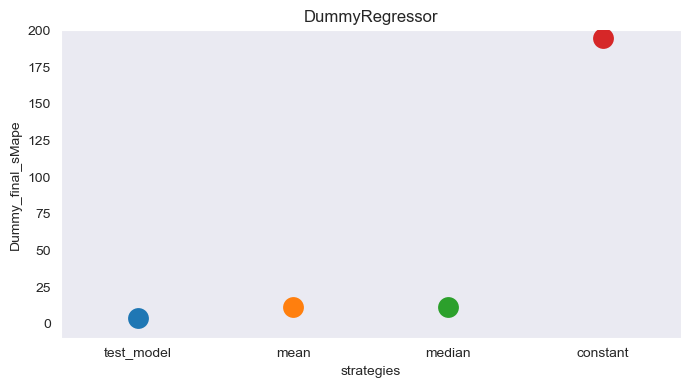

sMape test_model величина ошибки 3.36
sMape mean величина ошибки 10.98
sMape median величина ошибки 10.89
sMape constant величина ошибки 194.50


In [63]:
strategies = ['mean', 'median', 'constant']
strategies_to_fig = ['s_final_mape', 'mean_Dummy', 'median_Dummy', 'constant_Dummy']

test_scores = [{'test_model': s_final_mape}]
for s in strategies:
    if s == 'constant':
        dclf = DummyRegressor(strategy=s,  constant=1)
    else:
        dclf = DummyRegressor(strategy=s)
    rougher = dclf.fit(X_feat_ss, y_feat['rougher.output.recovery'])
    final = dclf.fit(X_feat_ss, y_feat['final.output.recovery'])
    predict_Dummy_rougher = rougher.predict(X_valid)
    predict_Dummy_final = final.predict(X_valid)
    Dummy_smape = (.25*final_smape_simple(final_teble_predict['rougher.output.recovery'], \
                                           predict_Dummy_rougher ) +
                    (.75*final_smape_simple(final_teble_predict['final.output.recovery'], \
                                            predict_Dummy_final)))

    test_scores.append({s: Dummy_smape})

plt.figure(figsize=(8, 4))
ax.set_ylim(-1,50)
ax = sns.stripplot(data=pd.DataFrame(test_scores), s=15);
ax.set_ylim(-10,200)
ax.set(xlabel='strategies', ylabel='Dummy_final_sMape', title= 'DummyRegressor')
plt.show()

for i in test_scores:
    print('sMape {} величина ошибки {:,.2f}'.format(*i.keys(), *i.values()))


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть сравнение с константной моделью - отлично, наше решение адекватно.

### Вывод
По результатам проведённого исследования и подбора лучшей модели по наименьшей ошибке sMape <br>
Лучший результат показала модель DecisionTreeRegressor для final.output.recovery c sMape 4.147869 <br>
С параметрами {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}<br>
<br>
И DecisionTreeRegressor для rougher.output.recovery с результатом sMape 2.025347 <br>
С параметрами {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}<br>
<br>
Для проверки на тестовых данных использовали модели с одним таргетом<br>
<br>
Все модели с мульти таргетом показали результат немного лучше или такой же как и модели с одним таргетом<br>
<br>
Предполагаем, что нет разницы для усредненных финальных значений, обучается ли модель на одном таргете или сразу на двух<br>
<br>
Объединив разные модели удалось показать финальную ошибку на тестовых данных <br>
Лучше, чем все ошибки на тренировочных данных<br>
<br>
Сравнение test sMape с Dummy моделями показало, что наша модель актуальна и делает адекватные предсказания<br>
Коэффициента восстановления золота в руде

## Общий вывод
Для компании "Цифры" после проведённых исследований коллекций данных<br>
data_full, data_train, data_test – обучены модели <br>
Для предсказаний коэффициента восстановления золота из золотосодержащей руды<br>
Модель для этапа флотации: rougher.output.recovery<br>
 - test_model_dtr = RandomForestRegressor('bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100)<br>
С минимальной ошибкой sMape 2.025347 на тренировочных данных <br>

Модель для финального этапа: final.output.recovery<br>
 - test_model_rfr = RandomForestRegressor('bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150)<br>
С минимальной ошибкой sMape 4.147869 на тренировочных данных<br>

Финальная ошибка sMape моделей равна: 3.36
<br>
В процессе исследования подтверждено правильность расчета rougher.output.recovery <br>
Данных по формуле:<br>
<img src='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg' width="600" height="150">
<br>
Проведено исследование отсутствующих признаков в тестовом датасете и пришли к заключению, что<br>
Некоторые отсутствующие признаки имеют характеристики целевых и корреляцию средней силы с целевым признаком<br>
Возможность интерпритации наступает после флотации и очистки, что не подходит для обучения модели<br>
Предположительно, по этим причинам признаки были удалены из тестового датасета<br>
В дальнейшем в обучаемом наборе были сохранены признаки тестовой выборки и два целевых признака<br>
Всего 54 столбца<br>
<br>

Изучены представленные наборы и пропуски в них<br>
Выявлено, что data_train и data_test являются частью data_full<br>
Восстановление пропусков было проведено только data_full<br>
Путём подставленния близ лежащим значением <br>
В дальнейшем data_train и data_test были восстановлены из data_full без пропусков<br>
<br>

Проведено исследование концентраций металлов на разных этапах очистки<br>
В процессе очистки концентрация золото (AU) увеличивается в 5.5 раза относительно первоначальной<br>
Концентрация серебра (AG) уменьшилась на 41% относительно первоначальной<br>
Концентрация свинца (PB) увеличивается в 2.8 раза относительно первоначальной<br>
<br>

Исследование распределения размера гранул сырья до флотации и до очистки <br>
Показало, что размеры гранул в выборках данных представлены взвешенно без искажений<br>
<br>

Концентрация всех элементов к финалу очистки стала плотнее<br>
В начальной руде диапазон концентрации элементов находился от 40 до 75 <br>
После финальной очистки диапазон ужался и находится приблизительно от 62 до 78<br>
Концентрация элементов в хвостах на этапах очистки, практически, не изменялась<br>
<br>
Удалены 


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Отличный итоговый вывод по проекту!

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Максим, проект получился на довольно хорошем уровне - ты хорошо постарался, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.

Работа с моделями также выполнена отлично: исследовано несколько алгоритмов, проведён подбор гиперпараметров с помощью `GridSearchCV`, выполнена промежуточная оценка моделей на кросс-валидации - молодец!
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)